# Set Up

## Imports 

In [10]:
!pip install keras_tuner

/usr/bin/bash: /opt/venv/Myrto/lib/libtinfo.so.6: no version information available (required by /usr/bin/bash)
  Using cached keras_tuner-1.1.3-py3-none-any.whl (135 kB)
  Using cached kt_legacy-1.0.4-py3-none-any.whl (9.6 kB)


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#Standard Libraries|
import os
from os import listdir
import pickle
#import optuna
import librosa
import numpy as np
import pandas as pd
from datetime import datetime

#Plots and Visuals
import re
import black
#import jupyter_black
#jupyter_black.load(lab=False, line_length=120)

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (10, 4)
plt.style.use('ggplot')
sns.set_style("darkgrid")
from scipy import stats

#Sci-kit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.metrics import RSquare

#Keras - Tensorflow
import keras
from keras import layers
import keras_tuner as kt
import tensorflow as tf

devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0], True)

from keras.models import Sequential
from tensorflow.keras import Model
from keras.layers import (
    Input, Flatten, Normalization, Embedding, Dense, Dropout, SpatialDropout2D, Activation,
    Conv1D, Conv2D, BatchNormalization, MaxPooling1D, MaxPooling2D, GlobalAvgPool1D, GlobalAveragePooling2D, LeakyReLU,
    Concatenate, Reshape, Bidirectional, GRU, LSTM, TimeDistributed, GlobalMaxPooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

#from keras.applications import VGG16
#from keras.applications.densenet import DenseNet201

2022-11-16 13:22:09.828184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 13:22:09.874571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 13:22:09.874763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Functions

In [2]:
def plot_learning_curves(model_history):
    # Plotting the MSE and the loss learning curves side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    MSE = model_history["mse"]
    val_MSE = model_history["val_mse"]
    epochs = range(1, len(MSE) + 1)
    ax1.plot(epochs, MSE, "g--", label="Training MSE")
    ax1.plot(epochs, val_MSE, "g", label="Validation MSE")
    ax1.set_title("Training and validation MSE", fontsize=15)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("MSE")
    ax1.legend()
    loss = model_history["loss"]
    val_loss = model_history["val_loss"]
    ax2.plot(epochs, loss, "r--", label="Training loss")
    ax2.plot(epochs, val_loss, "r", label="Validation loss")
    ax2.set_title("Training and validation loss", fontsize=15)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    return plt.show()

In [3]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [4]:
def report(model, X_test):
    predictions = model.predict(X_test).flatten().round(0).astype(int)

    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)

    temp = pd.DataFrame(model.predict(X_test).flatten().round(0).astype(int), index=X_audio_test.index)
    true_ranks = y_test.argsort().argsort()
    predicted_ranks = temp.iloc[:,0].argsort().argsort()

    metric = RSquare()
    metric.update_state(y_test, predictions)
    result = metric.result()
    R2 = result.numpy()

    sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
    print(f"MAE: {mae}\nMSE: {mse}\nSpearman's Correlation: {sp[0]}\nR Squared: {R2}")

    results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)

    ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
    ax.set(xlabel='Golden Truth', ylabel='Predictions');
    plt.ylim(reversed(plt.ylim()));
    plt.yticks(rotation=90);
    
    return mae, mse, sp, R2

## Load Data 

In [5]:
# Spotify Features
with open("spotify_features.pkl", "rb") as z:
    (X_audio_train, X_audio_val, X_audio_test) = pickle.load(z)
    
# Genres
with open("genres.pkl", "rb") as z:
    (X_genres_train, X_genres_val, X_genres_test) = pickle.load(z)

# Mel Spectrograms
with open("mel_spectrograms.pkl", "rb") as z:
    (X_mel_train, X_mel_val, X_mel_test) = pickle.load(z)
    
with open("mfccs.pkl", "rb") as z:
    (X_mfccs_train, X_mfccs_val, X_mfccs_test) = pickle.load(z)

# Youtube Views
with open("youtube_views.pkl", "rb") as z:
    (X_views_train, X_views_val, X_views_test) = pickle.load(z)

with open("static_views.pkl", "rb") as z:
    (X_static_views_train, X_static_views_val, X_static_views_test) = pickle.load(z)
    
#Target
with open("target.pkl", "rb") as z:
    (y_train, y_val, y_test) = pickle.load(z)
       
print(list(X_audio_train.columns))

['explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'year', 'month', 'time_signature_1.0', 'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0']


In [6]:
X_mel_train = np.array([scale_minmax(x, 0, 255).astype(np.uint8)/255 for x in X_mel_train.mel_spectrogram])
X_mel_val = np.array([scale_minmax(x, 0, 255).astype(np.uint8)/255 for x in X_mel_val.mel_spectrogram])
X_mel_test = np.array([scale_minmax(x, 0, 255).astype(np.uint8)/255 for x in X_mel_test.mel_spectrogram])

In [7]:
#For sequence data, n_channels aren't needed
img_height, img_width, n_channels = 128, 1292, 1

X_mel_train = X_mel_train.transpose((0,2,1)).reshape(X_mel_train.shape[0], img_height, img_width, n_channels)
X_mel_val = X_mel_val.transpose((0,2,1)).reshape(X_mel_val.shape[0], img_height, img_width, n_channels)
X_mel_test = X_mel_test.transpose((0,2,1)).reshape(X_mel_test.shape[0], img_height, img_width, n_channels)

X_mel_train.shape, X_mfccs_train.shape

((8601, 128, 1292, 1), (8601, 39))

## Some Preprocessing 

In [8]:
base_w = 1 / pd.Series(y_train).value_counts() / y_train.shape[0] * 100000
base_w = base_w.to_dict()
sample_weight = np.array([np.round(base_w[x], 2) for x in y_train]) + 10

## Generators 

In [9]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            X[i] = np.load(os.getcwd() + '/mfccs/' + ID + '.npy')
            X[i] = scale_minmax(X[i])

            # Store class
            y[i] = self.labels[ID]

        X = X.reshape(self.batch_size, 128, 1292, 1)
        
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

AttributeError: module 'keras.utils' has no attribute 'Sequence'

In [8]:
# Parameters
params = {'dim': (128, 1292),
          'batch_size': 21,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}

# Datasets
partition = {'train': list(y_train.index), 'validation': list(y_val.index), 'test': list(y_test.index)}
labels = pd.concat([y_train, y_val, y_test]).to_dict()

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
params = {'dim': (128, 1292),
          'batch_size': 13,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}
validation_generator = DataGenerator(partition['validation'], labels, **params)

#Test generator
params = {'dim': (128, 1292),
          'batch_size': 14,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}
testing_generator = DataGenerator(partition['test'], labels, **params)

# CNN Focused Models

Mel-Spectrogram Image is converted to grayscale in order to cut down computation and achieve reasonable training times.

## CNN

In [18]:
def simple_cnn_model(n_layers = 3, img_height = 128, img_width = 1292, n_channels=1):
    
    mel_input = Input(shape=(img_height, img_width, n_channels), name="MEL_INPUT")
    
    #Mel
    x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(mel_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
        
    for i in range(n_layers - 1):
        x = Conv2D(32 * (2**i), kernel_size=(3, 3), strides=3 , padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
        x = Dropout(0.3)(x)
        
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    mel_out = Dense(1, name="MEL_OUTPUT")(x)
    
    model = Model(inputs=mel_input, outputs=mel_out)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()
    return model

In [19]:
keras.backend.clear_session()
model = simple_cnn_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MEL_INPUT (InputLayer)      [(None, 128, 1292, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 64, 646, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 64, 646, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 323, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 108, 32)       9248      
                                                                 
 batch_normalization_1 (Batc  (None, 11, 108, 32)      128   

2022-11-13 18:59:50.365698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 18:59:50.366662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 18:59:50.366859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 18:59:50.366999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

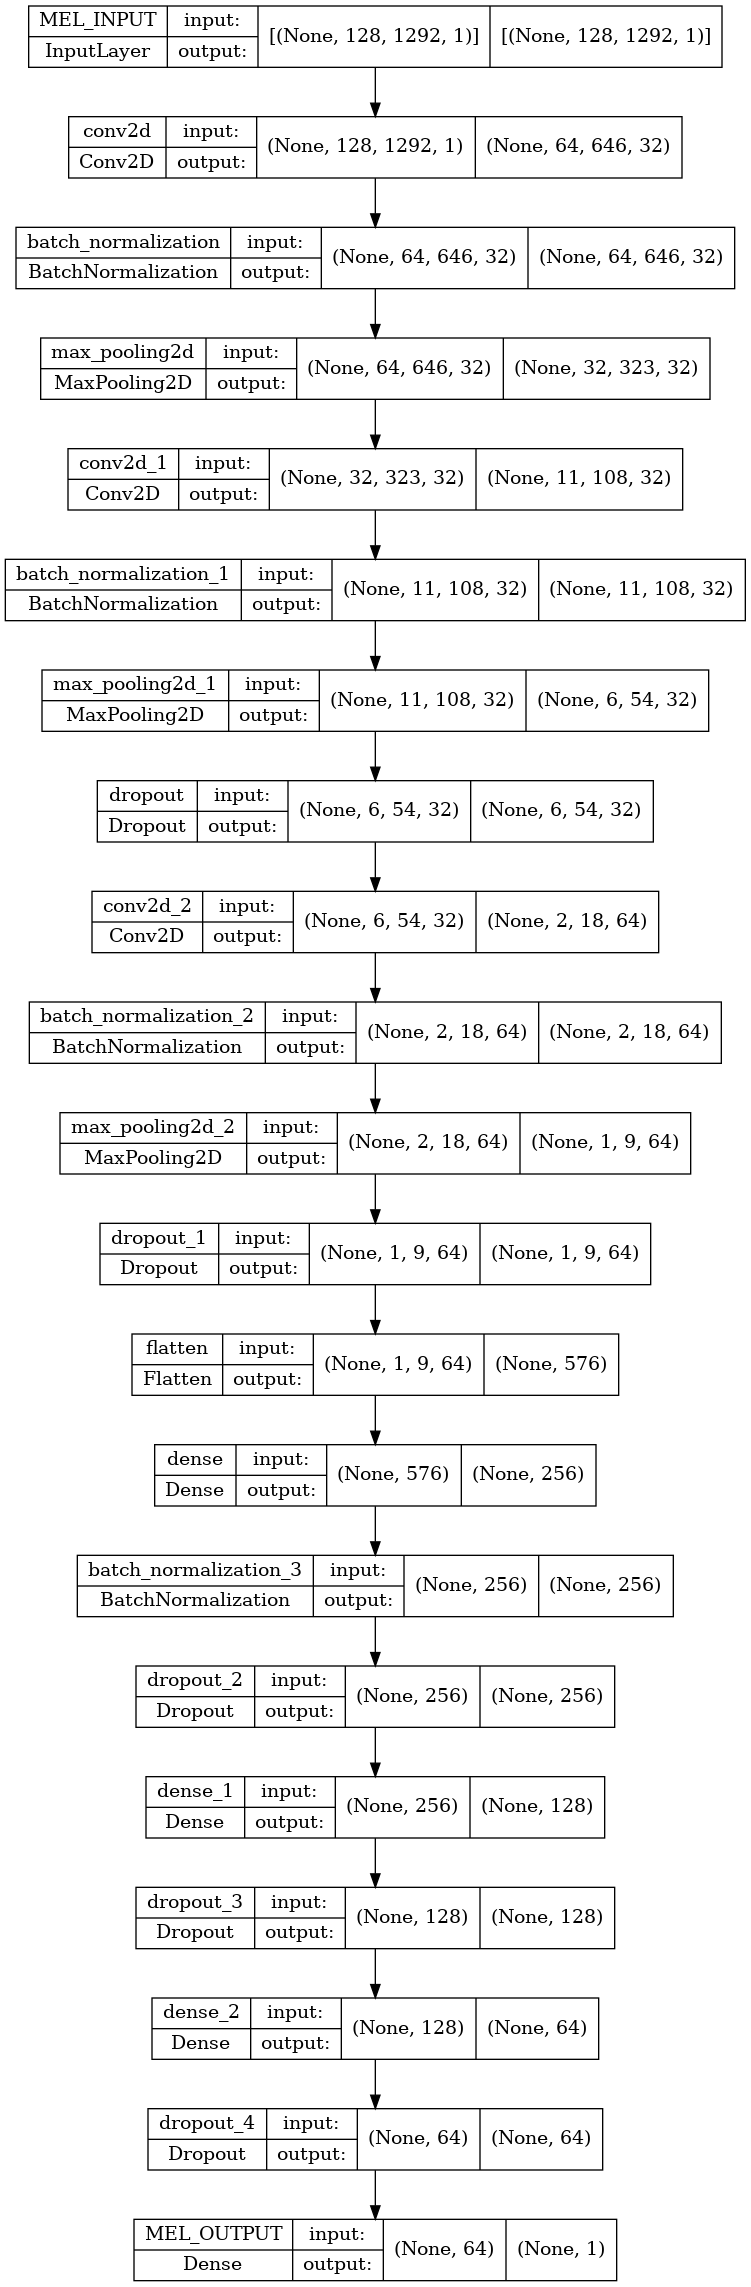

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
checkpoint = ModelCheckpoint(filepath='simple_cnn_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)

history = model.fit(
        X_mel_train, y_train,
        sample_weight=sample_weight,
        validation_data=[X_mel_val, y_val],
        batch_size=16,
        epochs=100,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

2022-11-13 18:59:55.010115: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.
2022-11-13 18:59:58.296293: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.


Epoch 1/100


2022-11-13 19:00:01.289031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


  1/538 [..............................] - ETA: 21:31 - loss: 273.8575 - mse: 1063.0613 - mae: 27.7588

2022-11-13 19:00:02.266629: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


538/538 [==============================] - 10s 13ms/step - loss: 189.8022 - mse: 577.0165 - mae: 19.2993 - val_loss: 13.4713 - val_mse: 311.9818 - val_mae: 14.1453 - lr: 1.0000e-04
Epoch 2/100
538/538 [==============================] - 7s 12ms/step - loss: 131.8148 - mse: 281.0147 - mae: 13.5936 - val_loss: 12.9969 - val_mse: 288.8293 - val_mae: 13.6708 - lr: 1.0000e-04
Epoch 3/100
538/538 [==============================] - 7s 12ms/step - loss: 130.2590 - mse: 271.0600 - mae: 13.4467 - val_loss: 13.0856 - val_mse: 293.0637 - val_mae: 13.7589 - lr: 1.0000e-04
Epoch 4/100
538/538 [==============================] - 7s 12ms/step - loss: 129.5950 - mse: 269.2521 - mae: 13.3814 - val_loss: 12.8428 - val_mse: 279.6979 - val_mae: 13.5201 - lr: 1.0000e-04
Epoch 5/100
538/538 [==============================] - 7s 12ms/step - loss: 128.8733 - mse: 266.8243 - mae: 13.3069 - val_loss: 12.9143 - val_mse: 286.4773 - val_mae: 13.5871 - lr: 1.0000e-04
Epoch 6/100
538/538 [==============================

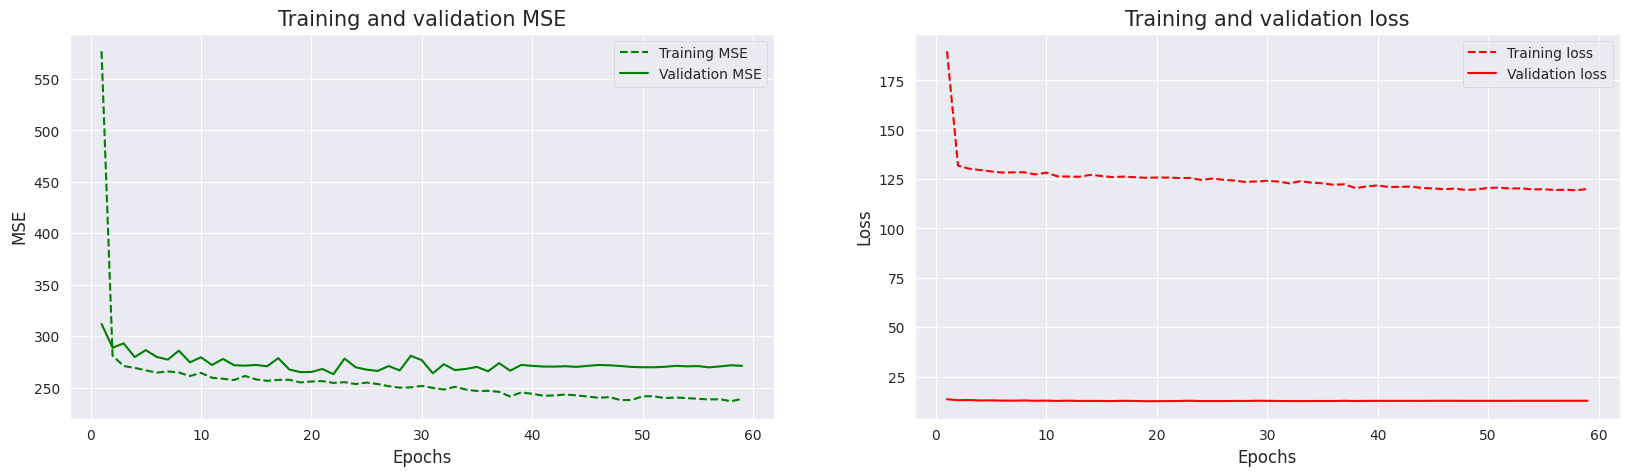

In [22]:
plot_learning_curves(history.history)

MAE: 14.886617100371748
MSE: 326.1802973977695
Spearman's Correlation: 0.12263710541442817
R Squared: 0.008089303970336914


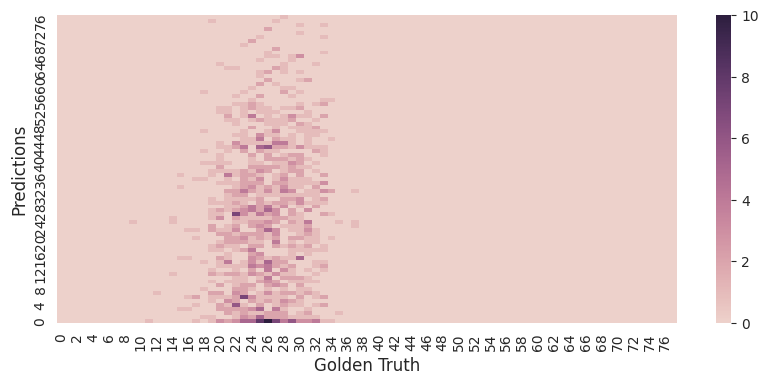

In [24]:
model.load_weights("simple_cnn_model.h5")
cnn_mae, cnn_mse, cnn_sp, cnn_r2 = report(model, X_mel_test)

In [23]:
model.load_weights("simple_cnn_model.h5")
print(model.evaluate(X_mel_test, y_test)) #326, 319 -- 323 with att 320

temp = pd.DataFrame(model.predict(X_mel_test).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

print(stats.spearmanr(true_ranks, predicted_ranks)) #0.16

34/34 [==============================] - 0s 10ms/step - loss: 14.2049 - mse: 326.0871 - mae: 14.8798
[14.2048921585083, 326.0871276855469, 14.879826545715332]
SpearmanrResult(correlation=0.12263710541442817, pvalue=5.4986383088714625e-05)


## CRNN 

In [20]:
import keras.backend as K
def crnn_model(n_layers = 3, img_height = 128, img_width = 1292, n_channels=1):
    
    mel_input = Input(shape=(img_height, img_width, n_channels), name="MEL_INPUT")
    
    #Mel
    x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(mel_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
        
    for i in range(n_layers - 1):
        x = Conv2D(32 * (2**i), kernel_size=(3, 3), strides=3 , padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
        x = Dropout(0.3)(x)
    
     #https://stackoverflow.com/questions/64150587/combining-cnn-and-bidirectional-lstm
    def ReshapeLayer(x):
        shape = x.shape
        # 1 possibility: H,W*channel
        #reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
        
        transpose = layers.Permute((2,1,3))(x)
        reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
        return reshape
    
    print(x.shape)
    x = layers.Lambda(ReshapeLayer)(x)
    print(x.shape)
    x = Bidirectional(GRU(32, return_sequences=True))(x)

    for i in range(2):
        x = Bidirectional(GRU(64, return_sequences=True))(x)
    
    #x = GlobalAvgPool1D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2, name="MEL_OUTPUT")(x)
    main_output = Dense(1)(x)

    model = Model(inputs=mel_input, outputs=main_output)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()
    return model

In [21]:
keras.backend.clear_session()
model = crnn_model()

(None, 1, 9, 64)
(None, 1, 576)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MEL_INPUT (InputLayer)      [(None, 128, 1292, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 64, 646, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 64, 646, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 323, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 108, 32)       9248      
                                                                 
 batch_normalization_1 (Batc 

In [22]:
checkpoint = ModelCheckpoint(filepath='crnn_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)

history = model.fit(
        X_mel_train, y_train,
        sample_weight=sample_weight,
        validation_data=[X_mel_val, y_val],
        batch_size=16,
        epochs=100,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

2022-11-13 18:34:31.432310: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.
2022-11-13 18:34:34.714303: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.


Epoch 1/100
538/538 [==============================] - 14s 17ms/step - loss: 155.8296 - mse: 398.8129 - mae: 15.8851 - val_loss: 20.0707 - val_mse: 610.5010 - val_mae: 19.9846 - lr: 1.0000e-04
Epoch 2/100
538/538 [==============================] - 8s 15ms/step - loss: 127.9608 - mse: 256.0904 - mae: 13.1482 - val_loss: 13.1874 - val_mse: 264.4498 - val_mae: 13.2076 - lr: 1.0000e-04
Epoch 3/100
538/538 [==============================] - 8s 15ms/step - loss: 128.0441 - mse: 256.7470 - mae: 13.1629 - val_loss: 13.0980 - val_mse: 264.2657 - val_mae: 13.2036 - lr: 1.0000e-04
Epoch 4/100
538/538 [==============================] - 8s 15ms/step - loss: 127.8572 - mse: 256.5421 - mae: 13.1522 - val_loss: 12.9441 - val_mse: 258.7546 - val_mae: 13.1047 - lr: 1.0000e-04
Epoch 5/100
538/538 [==============================] - 8s 15ms/step - loss: 127.3049 - mse: 253.7402 - mae: 13.1059 - val_loss: 12.8614 - val_mse: 256.7921 - val_mae: 13.0581 - lr: 1.0000e-04
Epoch 6/100
538/538 [==================

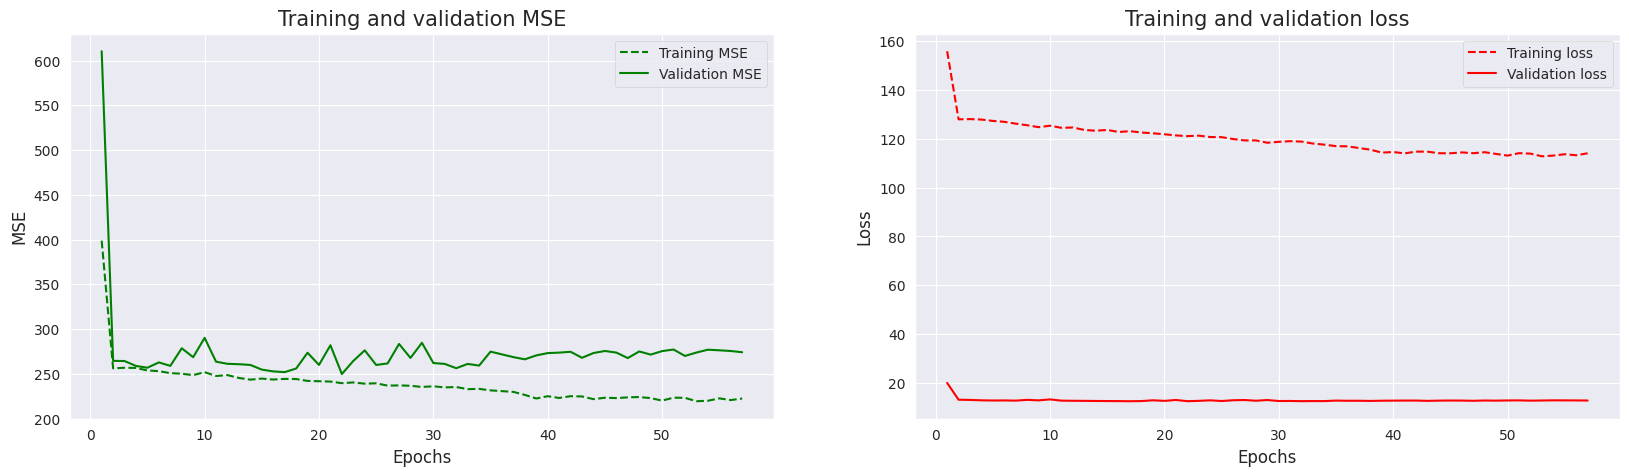

In [23]:
plot_learning_curves(history.history)

MAE: 14.928438661710038
MSE: 324.5157992565056
Spearman's Correlation: 0.14009970252035314
R Squared: 0.013150990009307861


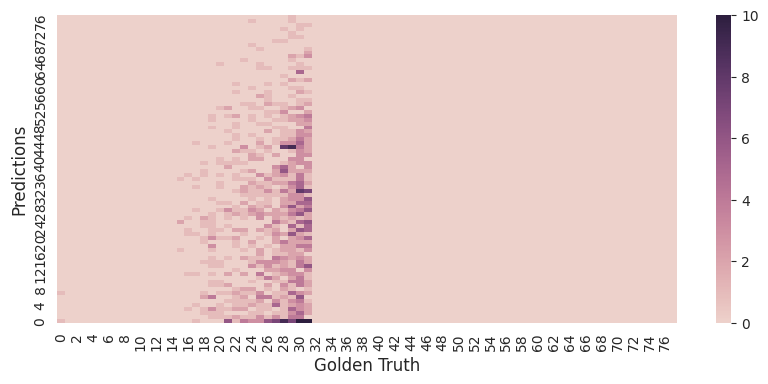

In [24]:
model.load_weights("crnn_model.h5")
crnn_mae, crnn_mse, crnn_sp, crnn_r2 = report(model, X_mel_test)

## All Data

In [16]:
# CREATE TWO INPUT MODEL
def crnn2_model(n_layers = 6, img_height = 128, img_width = 1292, n_channels = 1):
    
    mel_input = Input(shape=(img_height, img_width, n_channels), name="MEL_INPUT")
    
    #Mel
    x = vgg_model.output
    #x = Flatten()(x) # Flatten dimensions to for use in FC layers
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(0.4,  name="MEL_OUTPUT")(x) # Dropout layer to reduce overfitting
    
     #https://stackoverflow.com/questions/64150587/combining-cnn-and-bidirectional-lstm
    def ReshapeLayer(x):
        shape = x.shape
        # 1 possibility: H,W*channel
        reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
        
        #transpose = layers.Permute((2,1,3))(x)
        #reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
        return reshape
    
    print(x.shape)
    x = layers.Lambda(ReshapeLayer)(x)
    print(x.shape)
    x = Bidirectional(GRU(32, return_sequences=True))(x)

    for i in range(2):
        x = Bidirectional(GRU(64, return_sequences=True))(x)
    
    #x = GlobalAvgPool1D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2, name="MEL_OUTPUT")(x)
    main_output = Dense(1)(x)

    model = Model(inputs=vgg_model.input, outputs=main_output)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()
    return model

In [17]:
keras.backend.clear_session()
model = crnn2_model()

(None, 4, 40, 512)
(None, 4, 20480)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1292, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 1292, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 1292, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 646, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 646, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 646, 128)      147584    
                                                                 
 block2_pool (MaxPooling2

In [27]:
checkpoint = ModelCheckpoint(filepath='cnn_before_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

history = model.fit(
            training_generator,
            validation_data=validation_generator,
            epochs=100,
            #steps_per_epoch=len(X_audio_train)/16,
            callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/100


2022-11-15 15:20:04.239373: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-11-15 15:20:09.676049: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-15 15:20:13.795426: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-15 15:20:13.795464: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

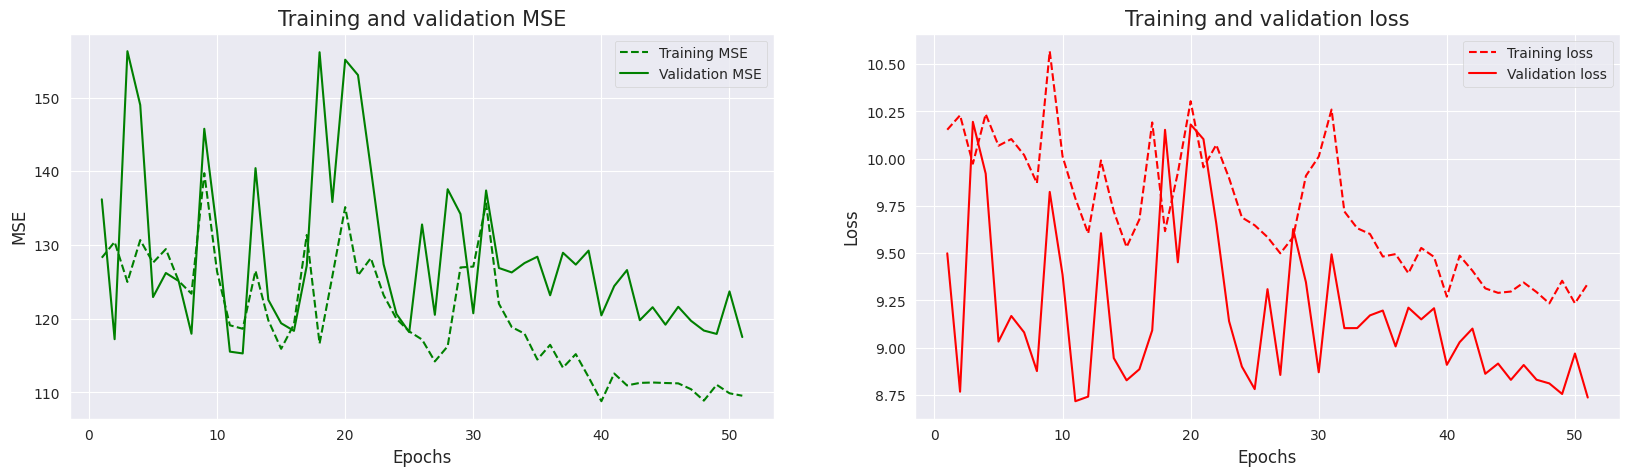

In [18]:
plot_learning_curves(history.history)

In [19]:
model.load_weights("cnn_model.h5")
model.evaluate([X_mel_test, X_audio_test, X_genre_test, X_views_test], y_test) #199

34/34 [==============================] - 1s 17ms/step - loss: 11.0215 - mse: 194.1249 - mae: 10.8694


[11.021535873413086, 194.12490844726562, 10.869394302368164]

34/34 [==============================] - 1s 16ms/step


<AxesSubplot:>

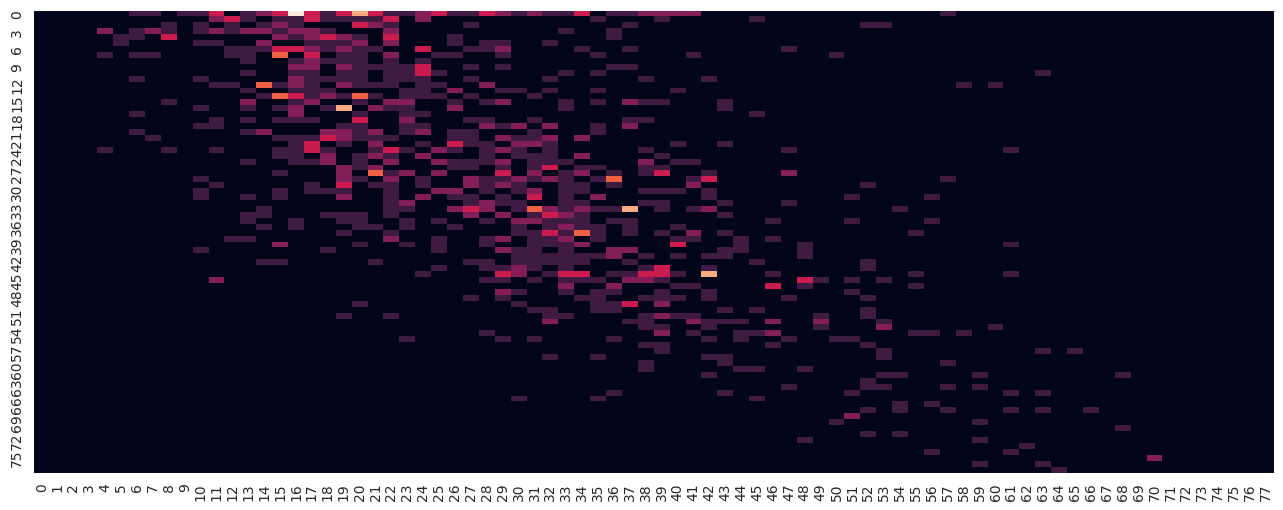

In [20]:
predictions = model.predict([X_mel_test, X_audio_test, X_genre_test, X_views_test]).flatten().round(0).astype(int)
results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
results['differences'] = np.abs(results.actual - results.predicted)

sns.heatmap(confusion_matrix(results.actual, results.predicted), cbar=False)

In [21]:
temp = pd.DataFrame(model.predict([X_mel_test, X_audio_test, X_genre_test, X_views_test]).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

stats.spearmanr(true_ranks, predicted_ranks) #0.33

34/34 [==============================] - 1s 15ms/step


SpearmanrResult(correlation=0.6193952298742484, pvalue=5.381041452562464e-115)

In [16]:
#Add Pretrained weights, tuning

# Pre-Trained CNN Models

In [24]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=16, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            X[i] = np.load(os.getcwd() + '/mfccs/' + ID + '.npy')
            X[i] = scale_minmax(X[i], 0, 255).astype(np.uint8) #convert to picture
            X[i] = X[i]/255 #normalization, followed strategy from ImageDataGenerator

            # Store class
            y[i] = self.labels[ID]
        
        X = np.repeat(X[:, :, :, np.newaxis], 3, -1)
        
        return X, y 

In [25]:
#Batch Size needs to match data exactly.
#Audio
y_pretrained = pd.concat([y_train, y_val, y_test])
y_pre_train = y_pretrained.iloc[:int(y_pretrained.shape[0] * 0.795)] #keep 80% of sorted data as train
y_pre_val = y_pretrained.iloc[int(y_pretrained.shape[0] * 0.795):int(y_pretrained.shape[0] * 0.905)] # 10% validation 
y_pre_test = y_pretrained.iloc[int(y_pretrained.shape[0] * 0.905):] # 10% test
print(y_pre_train.shape, y_pre_val.shape, y_pre_test.shape)

(8547,) (1183,) (1022,)


In [26]:
# Datasets
partition = {'train': list(y_pre_train.index), 'validation': list(y_pre_val.index), 'test': list(y_pre_test.index)}
labels = pd.concat([y_pre_train, y_pre_val, y_pre_test]).to_dict()

# Parameters
params = {'dim': (128, 1292),
          'batch_size': 21,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
params = {'dim': (128, 1292),
          'batch_size': 13,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}
validation_generator = DataGenerator(partition['validation'], labels, **params)

#Test generator
params = {'dim': (128, 1292),
          'batch_size': 14,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}
testing_generator = DataGenerator(partition['test'], labels, **params)

## VGG16 (Baseline)

### Freezed Weights 

In [9]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 1292, 3))

2022-11-14 16:56:04.035968: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 16:56:04.037031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:56:04.037226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:56:04.037366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
vgg_model.trainable = False

x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x) # Dropout layer to reduce overfitting
x = Dense(1, kernel_initializer='normal')(x) 

transfer_model = Model(inputs=vgg_model.input, outputs=x)

learning_rate= 0.001

transfer_model.compile(loss="logcosh", optimizer=Adam(lr=learning_rate),
                      metrics=[tf.keras.metrics.MeanSquaredError(name='mse'),
                               tf.keras.metrics.MeanAbsoluteError(name='mae')])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

transfer_history = transfer_model.fit(training_generator, epochs=30, validation_data=validation_generator, batch_size =16, callbacks=[reduce_o_p, earlystopper]) #change to train

Epoch 1/30


2022-11-14 16:56:11.553747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


  1/407 [..............................] - ETA: 41:16 - loss: 24.0850 - mse: 815.5755 - mae: 24.7782

2022-11-14 16:56:16.470273: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


407/407 [==============================] - 111s 259ms/step - loss: 13.1898 - mse: 294.9395 - mae: 13.8650 - val_loss: 12.5885 - val_mse: 266.5240 - val_mae: 13.2639 - lr: 0.0010
Epoch 2/30
407/407 [==============================] - 103s 253ms/step - loss: 13.0664 - mse: 288.5981 - mae: 13.7426 - val_loss: 12.2898 - val_mse: 250.9544 - val_mae: 12.9655 - lr: 0.0010
Epoch 3/30
407/407 [==============================] - 103s 254ms/step - loss: 12.8003 - mse: 279.5823 - mae: 13.4749 - val_loss: 12.2821 - val_mse: 252.3293 - val_mae: 12.9535 - lr: 0.0010
Epoch 4/30
407/407 [==============================] - 103s 253ms/step - loss: 12.7426 - mse: 276.1946 - mae: 13.4171 - val_loss: 14.1944 - val_mse: 346.1689 - val_mae: 14.8707 - lr: 0.0010
Epoch 5/30
407/407 [==============================] - 103s 253ms/step - loss: 12.7067 - mse: 277.2004 - mae: 13.3818 - val_loss: 12.9160 - val_mse: 284.8652 - val_mae: 13.5886 - lr: 0.0010
Epoch 6/30
407/407 [==============================] - 103s 253ms/s

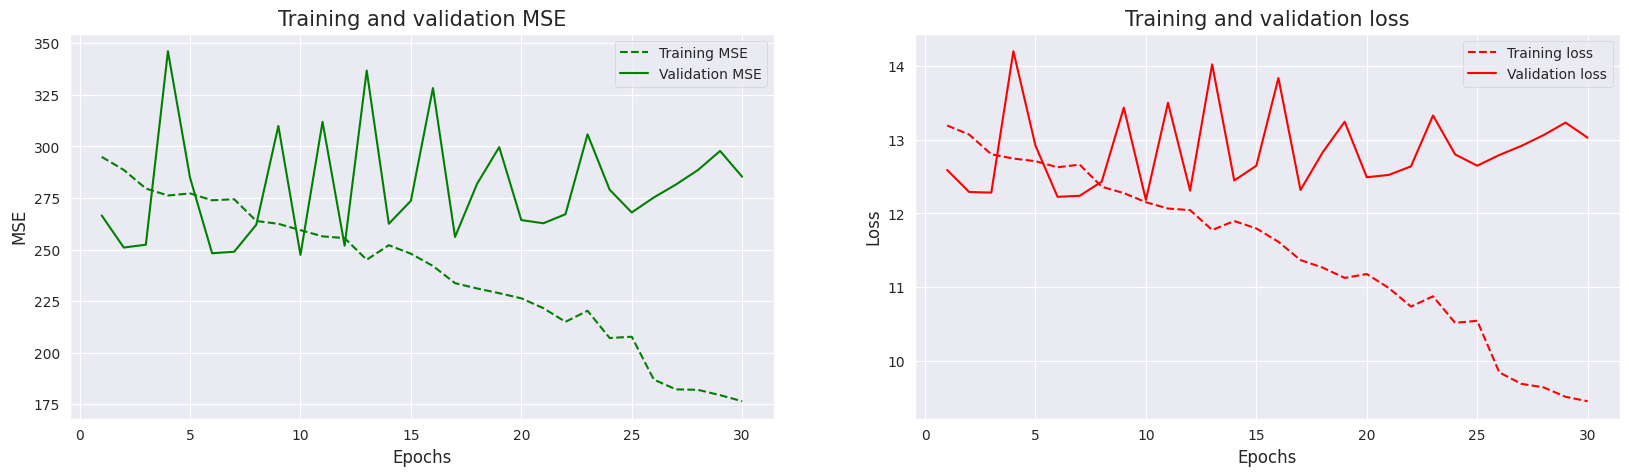

In [12]:
plot_learning_curves(transfer_history.history)

In [13]:
#Saving the freezed dense model
transfer_model.save('saved_transfer_model/my_model')

with open('saved_transfer_model_history_frozen', 'wb') as file_pi:
    pickle.dump(transfer_history, file_pi)

2022-11-14 17:47:55.365150: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_transfer_model/my_model/assets
INFO:tensorflow:Assets written to: ram://ab383622-ba36-40f2-b12e-214525d603cd/assets


In [14]:
#transfer_model = tf.keras.models.load_model('saved_transfer_model/my_model')
print(transfer_model.evaluate(testing_generator))

predictions = transfer_model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mel_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mel_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(transfer_model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

metric = RSquare()
metric.update_state(y_pre_test, predictions)
result = metric.result()
R2 = result.numpy()

cnn_mel_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mel_mae}\nMSE: {cnn_mel_mse}\nSpearman's Correlation: {cnn_mel_sp[0]}\nR Squared: {R2}")

73/73 [==============================] - 12s 133ms/step - loss: 14.4635 - mse: 348.1039 - mae: 15.1408
[14.46350383758545, 348.1038513183594, 15.140765190124512]
MAE: 15.137964774951076
MSE: 348.22211350293543
Spearman's Correlation: 0.17540557284632546
R Squared: -0.03776073455810547


In [18]:
print(transfer_model.evaluate(testing_generator))

predictions = transfer_model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mel_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mel_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(transfer_model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

cnn_mel_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mel_mae}\nMSE: {cnn_mel_mse}\nSpearman's Correlation {cnn_mel_sp[0]}")

73/73 [==============================] - 10s 133ms/step - loss: 14.3054 - mse: 339.0472 - mae: 14.9807
[14.305448532104492, 339.04718017578125, 14.98066520690918]
73/73 [==============================] - 10s 132ms/step
MAE: 14.972602739726028
MSE: 339.24461839530335
Spearman's Correlation 0.18474515729336397


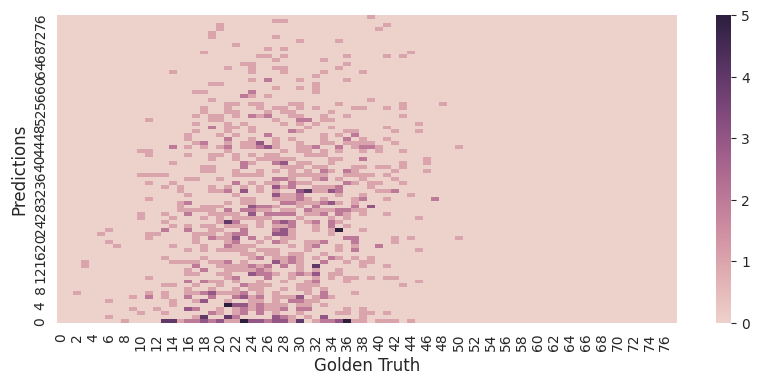

In [15]:
results = pd.DataFrame([y_pre_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

In [15]:
temp = pd.DataFrame(transfer_model.predict(testing_generator).flatten().round(0).astype(int))
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

stats.spearmanr(true_ranks, predicted_ranks) #0.48

73/73 [==============================] - 10s 132ms/step


SpearmanrResult(correlation=0.19286735277919959, pvalue=5.079266196093335e-10)

### Unfreezed Weights 

In [14]:
#Restart Kernel, run the below
from keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 1292, 3))

ImportError: cannot import name 'VGG16' from 'keras.applications' (/usr/local/lib/python3.8/dist-packages/keras/applications/__init__.py)

In [16]:
keras.backend.clear_session()
new_model = tf.keras.models.load_model('saved_transfer_model/my_model')
#Fine-tuning with a small learning-rate
vgg_model.trainable = True

learning_rate= 0.0001

new_model.compile(loss="logcosh", optimizer=Adam(lr=learning_rate),
                      metrics=[tf.keras.losses.MeanSquaredError(name='mse'),
                               tf.keras.metrics.MeanAbsoluteError(name='mae')])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
checkpoint = ModelCheckpoint(filepath='unfreezed_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=8, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

new_history = new_model.fit(training_generator, epochs=20, validation_data=validation_generator, callbacks=[checkpoint, reduce_o_p, earlystopper]) #change to train

Epoch 1/20
407/407 [==============================] - 104s 254ms/step - loss: 9.3935 - mse: 174.8526 - mae: 10.0582 - val_loss: 13.1371 - val_mse: 290.0182 - val_mae: 13.8112 - lr: 1.0000e-04
Epoch 2/20
407/407 [==============================] - 103s 253ms/step - loss: 9.3420 - mse: 172.6683 - mae: 10.0048 - val_loss: 13.3357 - val_mse: 301.4915 - val_mae: 14.0130 - lr: 1.0000e-04
Epoch 3/20
407/407 [==============================] - 103s 253ms/step - loss: 9.3413 - mse: 172.8754 - mae: 10.0050 - val_loss: 13.5094 - val_mse: 310.6486 - val_mae: 14.1852 - lr: 1.0000e-04
Epoch 4/20
407/407 [==============================] - 103s 253ms/step - loss: 9.2738 - mse: 172.3301 - mae: 9.9369 - val_loss: 13.4482 - val_mse: 307.5138 - val_mae: 14.1245 - lr: 1.0000e-04
Epoch 5/20
407/407 [==============================] - 103s 253ms/step - loss: 9.1054 - mse: 166.7408 - mae: 9.7676 - val_loss: 13.4327 - val_mse: 307.1969 - val_mae: 14.1085 - lr: 1.0000e-04
Epoch 6/20
407/407 [======================

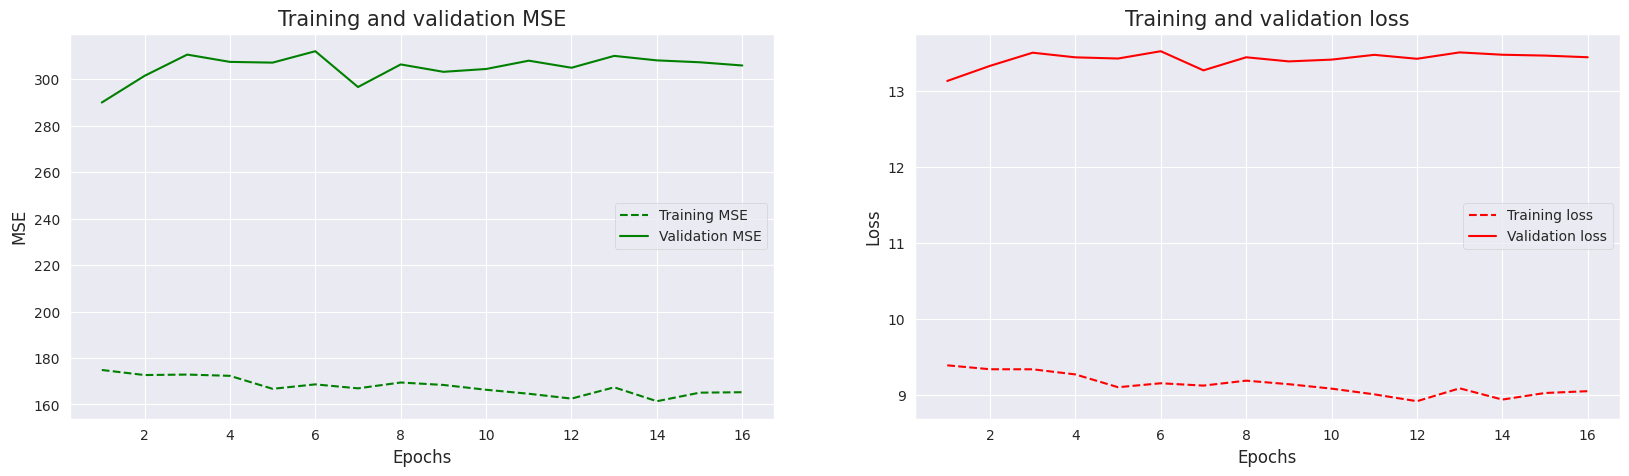

In [18]:
plot_learning_curves(new_history.history)

In [19]:
new_model.load_weights("unfreezed_model.h5")
print(new_model.evaluate(testing_generator))

predictions = new_model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mel_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mel_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(new_model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

metric = RSquare()
metric.update_state(y_pre_test, predictions)
result = metric.result()
R2 = result.numpy()

cnn_mel_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mel_mae}\nMSE: {cnn_mel_mse}\nSpearman's Correlation: {cnn_mel_sp[0]}\nR Squared: {R2}")

73/73 [==============================] - 10s 133ms/step - loss: 14.4688 - mse: 350.2787 - mae: 15.1450
[14.468836784362793, 350.2786865234375, 15.145029067993164]
MAE: 15.12720156555773
MSE: 350.0352250489237
Spearman's Correlation: 0.17657372350357448
R Squared: -0.04316413402557373


In [24]:
new_model.load_weights("unfreezed_model.h5")
print(new_model.evaluate(testing_generator))

predictions = new_model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mel_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mel_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(new_model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

cnn_mel_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mel_mae}\nMSE: {cnn_mel_mse}\nSpearman's Correlation {cnn_mel_sp[0]}")

73/73 [==============================] - 10s 133ms/step - loss: 14.3171 - mse: 345.1684 - mae: 14.9952
[14.317063331604004, 345.1684265136719, 14.99521255493164]
73/73 [==============================] - 10s 132ms/step
MAE: 14.99119373776908
MSE: 345.2769080234834
Spearman's Correlation 0.18200040288848757


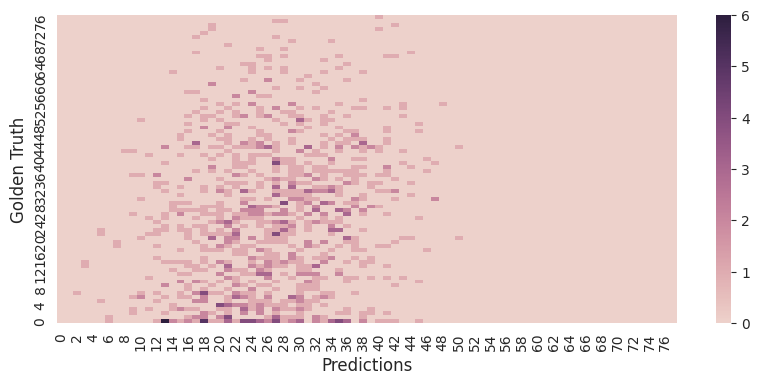

In [20]:
results = pd.DataFrame([y_pre_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Predictions', ylabel='Golden Truth');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

## DenseNet201 

### Freezed Weights 

In [21]:
from tensorflow.keras.applications.densenet import DenseNet201
dense_net = DenseNet201(include_top=False, weights="imagenet", input_shape=(128, 1292, 3), pooling="max")

In [22]:
dense_net.trainable = False

x = dense_net.output
x = Dense(units = 64,kernel_initializer='glorot_uniform', activation='relu')(x)
x = Dropout(rate=0.4)(x)
x = Dense(1, kernel_initializer='normal')(x)

transfer_model = Model(inputs=dense_net.input, outputs=x)

learning_rate= 0.001

transfer_model.compile(loss="logcosh", optimizer=Adam(lr=learning_rate),
                      metrics=[tf.keras.metrics.MeanSquaredError(name='mse'),
                               tf.keras.metrics.MeanAbsoluteError(name='mae')])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25)

transfer_history = transfer_model.fit(training_generator, epochs=30, validation_data=validation_generator, callbacks=[reduce_o_p, earlystopper]) #change to train

Epoch 1/30
407/407 [==============================] - 91s 207ms/step - loss: 12.9627 - mse: 282.4633 - mae: 13.6378 - val_loss: 12.6589 - val_mse: 270.5849 - val_mae: 13.3347 - lr: 0.0010
Epoch 2/30
407/407 [==============================] - 81s 200ms/step - loss: 12.7173 - mse: 272.8965 - mae: 13.3930 - val_loss: 12.3270 - val_mse: 249.5746 - val_mae: 13.0041 - lr: 0.0010
Epoch 3/30
407/407 [==============================] - 81s 199ms/step - loss: 12.5569 - mse: 266.2997 - mae: 13.2299 - val_loss: 12.3086 - val_mse: 248.8644 - val_mae: 12.9878 - lr: 0.0010
Epoch 4/30
407/407 [==============================] - 81s 200ms/step - loss: 12.5999 - mse: 266.2165 - mae: 13.2762 - val_loss: 13.9339 - val_mse: 333.1029 - val_mae: 14.6089 - lr: 0.0010
Epoch 5/30
407/407 [==============================] - 81s 199ms/step - loss: 12.4497 - mse: 260.9470 - mae: 13.1235 - val_loss: 13.1864 - val_mse: 296.0797 - val_mae: 13.8615 - lr: 0.0010
Epoch 6/30
407/407 [==============================] - 81s 19

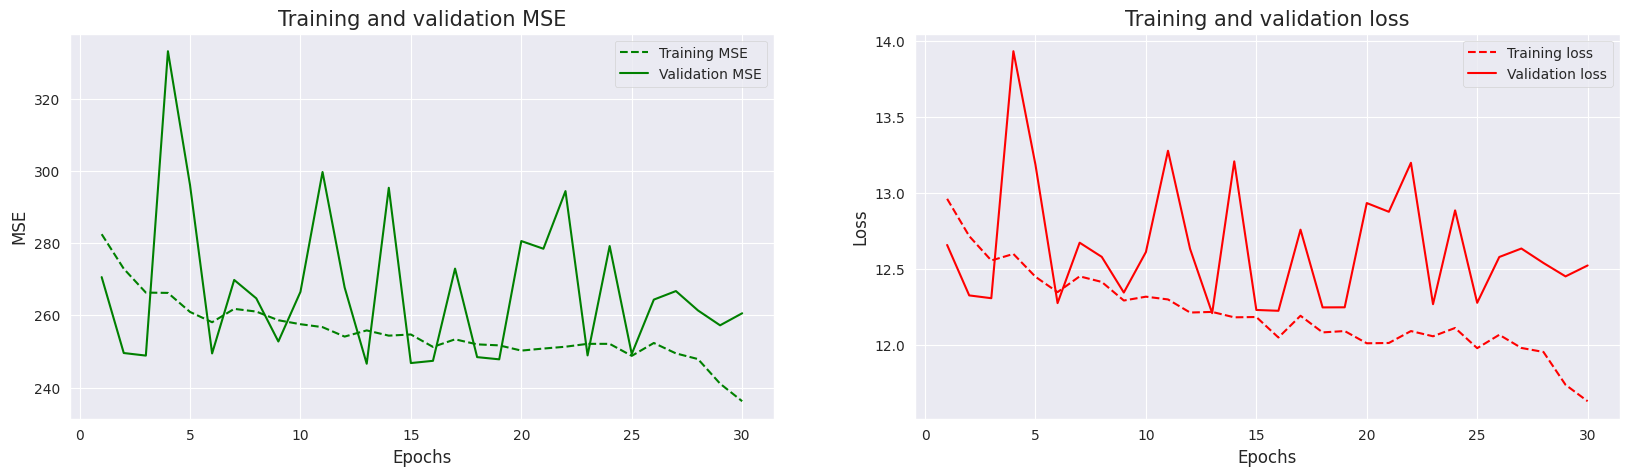

In [24]:
plot_learning_curves(transfer_history.history)

In [25]:
#Saving the freezed dense model
transfer_model.save('saved_transfer_model/dense_model')

with open('saved_transfer_model_history_frozen_dense', 'wb') as file_pi:
    pickle.dump(transfer_history, file_pi)

INFO:tensorflow:Assets written to: saved_transfer_model/dense_model/assets
INFO:tensorflow:Assets written to: ram://6daaefae-8355-4b37-b6b0-69671e6890c3/assets


In [26]:
print(transfer_model.evaluate(testing_generator))

predictions = transfer_model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mel_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mel_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(transfer_model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

metric = RSquare()
metric.update_state(y_pre_test, predictions)
result = metric.result()
R2 = result.numpy()

cnn_mel_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mel_mae}\nMSE: {cnn_mel_mse}\nSpearman's Correlation: {cnn_mel_sp[0]}\nR Squared: {R2}")

73/73 [==============================] - 10s 111ms/step - loss: 14.3048 - mse: 336.9764 - mae: 14.9819
[14.304814338684082, 336.97637939453125, 14.981905937194824]
MAE: 14.983365949119374
MSE: 337.3414872798434
Spearman's Correlation: 0.14588375844809995
R Squared: -0.005334615707397461


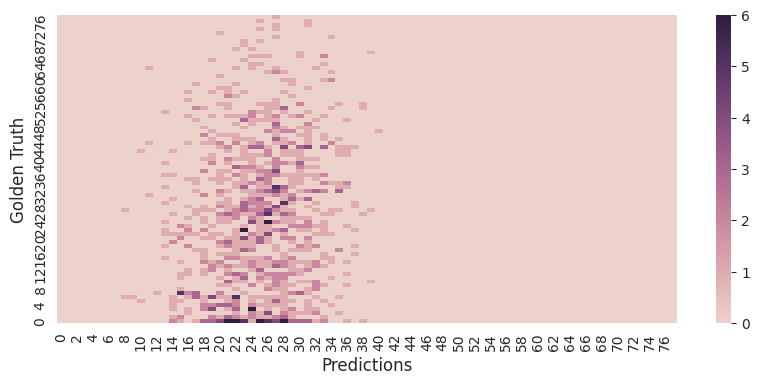

In [27]:
results = pd.DataFrame([y_pre_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Predictions', ylabel='Golden Truth');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

### Unfreezed Weights 

In [18]:
from keras.applications.densenet import DenseNet201
dense_net = DenseNet201(include_top=False, weights="imagenet", input_shape=(128, 1292, 3), pooling="max")

In [28]:
new_model = tf.keras.models.load_model('saved_transfer_model/dense_model')
#Fine-tuning with a small learning-rate
dense_net.trainable = True

learning_rate= 0.0001

new_model.compile(loss="logcosh", optimizer=Adam(lr=learning_rate),
                      metrics=[tf.keras.losses.MeanSquaredError(name='mse'),
                               tf.keras.metrics.MeanAbsoluteError(name='mae')])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
checkpoint = ModelCheckpoint(filepath='unfreezed_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=8, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

new_history = new_model.fit(training_generator, epochs=20 , validation_data=validation_generator, callbacks=[checkpoint, reduce_o_p, earlystopper]) #change to train

Epoch 1/20
407/407 [==============================] - 90s 208ms/step - loss: 11.7363 - mse: 240.9115 - mae: 12.4086 - val_loss: 12.3766 - val_mse: 253.8811 - val_mae: 13.0514 - lr: 1.0000e-04
Epoch 2/20
407/407 [==============================] - 83s 203ms/step - loss: 11.6684 - mse: 238.1325 - mae: 12.3411 - val_loss: 12.4881 - val_mse: 258.9496 - val_mae: 13.1631 - lr: 1.0000e-04
Epoch 3/20
407/407 [==============================] - 82s 202ms/step - loss: 11.6276 - mse: 236.7995 - mae: 12.2996 - val_loss: 12.4199 - val_mse: 255.8197 - val_mae: 13.0953 - lr: 1.0000e-04
Epoch 4/20
407/407 [==============================] - 83s 203ms/step - loss: 11.6498 - mse: 238.3608 - mae: 12.3220 - val_loss: 12.4443 - val_mse: 256.9899 - val_mae: 13.1198 - lr: 1.0000e-04
Epoch 5/20
407/407 [==============================] - 83s 203ms/step - loss: 11.6673 - mse: 239.5054 - mae: 12.3397 - val_loss: 12.5453 - val_mse: 261.6233 - val_mae: 13.2211 - lr: 1.0000e-04
Epoch 6/20
407/407 [====================

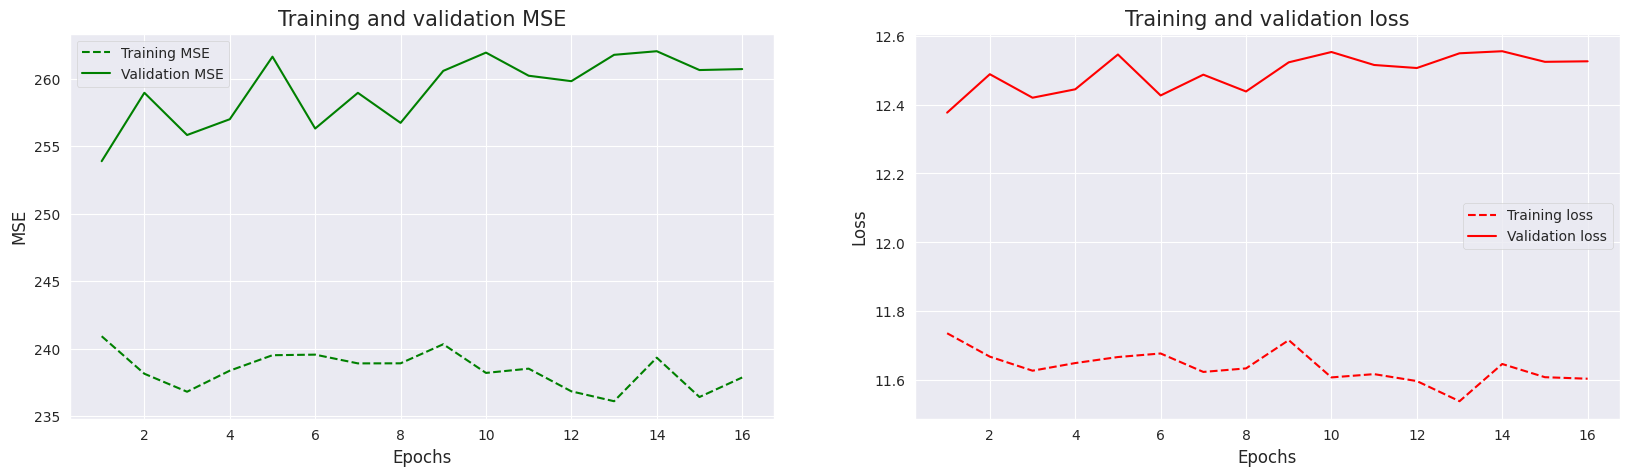

In [30]:
plot_learning_curves(new_history.history)

In [31]:
new_model.load_weights("unfreezed_model.h5")
print(new_model.evaluate(testing_generator))

predictions = new_model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mel_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mel_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(new_model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

metric = RSquare()
metric.update_state(y_pre_test, predictions)
result = metric.result()
R2 = result.numpy()

cnn_mel_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mel_mae}\nMSE: {cnn_mel_mse}\nSpearman's Correlation: {cnn_mel_sp[0]}\nR Squared: {R2}")

73/73 [==============================] - 8s 114ms/step - loss: 14.3264 - mse: 336.1988 - mae: 14.9997
[14.326376914978027, 336.1988220214844, 14.99970531463623]
MAE: 14.99119373776908
MSE: 336.0264187866928
Spearman's Correlation: 0.15375414160321302
R Squared: -0.0014154911041259766


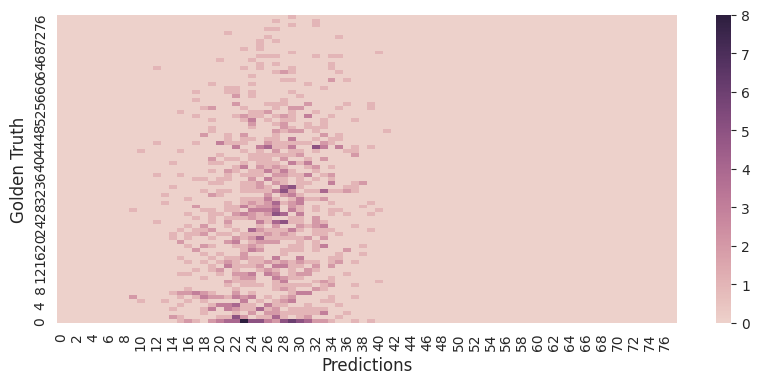

In [23]:
results = pd.DataFrame([y_pre_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Predictions', ylabel='Golden Truth');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

# Final Model 

The final model will include the architecture that worked best for the specrograms, as well as the rest of the data (audio features+genres, youtube views)

## Before Song Release 

### Data Generator 

In [9]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
#only generates spectrograms
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, all_inds, list_IDs, labels, audio, genre, batch_size, dim=(128, 1292), n_channels=1, 
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.all_inds = all_inds
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
        self.audio = audio
        self.genre = genre
        #self.n = 0
        #self.max = self.__len__()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        batch_indices = [self.all_inds[k] for k in indexes]

        # Generate data
        mel = self.__data_generation1(list_IDs_temp)
        audio, genre, y = self.__data_generation2(batch_indices)

        X = [mel, audio, genre]
        
        return X, y #{'audio':audio,'genre':genre,'views':views},y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __data_generation1(self, list_IDs_temp):
        # Initialization
        mel = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            mel[i] = np.load(os.getcwd() + '/mfccs/' + ID + '.npy')
            mel[i] = scale_minmax(mel[i], 0, 255).astype(np.uint8) #convert to picture
            mel[i] = mel[i]/255 #normalization, followed strategy from ImageDataGenerator

            # Store class
            #y[i] = self.labels[ID]
        
        mel = np.repeat(mel[:, :, :, np.newaxis], 3, -1)
        
        return mel
        
    def __data_generation2(self, batch_indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
           
        # Generate data
        audio = self.audio[batch_indices,:]
        # note that you need to stack the slice in order to reshape it to (num_samples,768)
        genre = self.genre[batch_indices,:] #np.stack(self.genre[batch_indices])
        # since batch_size is not a super large number, you can stack here
        #views = self.views[batch_indices,:] #np.stack([fn2img(seed) for seed in self.views[batch_indices]])
        y = self.labels[[batch_indices]]

        return audio, genre, y
    
        
        #return mel #, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

In [10]:
#Batch Size needs to match data exactly.
#Audio
y_pretrained = pd.concat([y_train, y_val, y_test])
y_pre_train = y_pretrained.iloc[:int(y_pretrained.shape[0] * 0.795)] #keep 80% of sorted data as train
y_pre_val = y_pretrained.iloc[int(y_pretrained.shape[0] * 0.795):int(y_pretrained.shape[0] * 0.905)] # 10% validation 
y_pre_test = y_pretrained.iloc[int(y_pretrained.shape[0] * 0.905):] # 10% test
print(y_pre_train.shape, y_pre_val.shape, y_pre_test.shape)

(8547,) (1183,) (1022,)


In [11]:
# Datasets
partition = {'train': list(y_pre_train.index), 'validation': list(y_pre_val.index), 'test': list(y_pre_test.index)}
labels = pd.concat([y_pre_train, y_pre_val, y_pre_test]).to_dict()

# Parameters
params = {'dim': (128, 1292),
          'batch_size': 21,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}

# Generators
training_generator = DataGenerator([i for i in range(0, len(y_pre_train))], partition['train'], y_pre_train.values,  X_audio_train.values, X_genres_train.values, **params)

params = {'dim': (128, 1292),
          'batch_size': 13,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}
validation_generator = DataGenerator([i for i in range(0, len(y_pre_val))], partition['validation'], y_pre_val.values,  X_audio_train.values, X_genres_train.values, **params)

params = {'dim': (128, 1292),
          'batch_size': 14,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}
testing_generator = DataGenerator([i for i in range(0, len(y_pre_test))], partition['test'], y_pre_test.values,  X_audio_train.values, X_genres_train.values, **params)

### Final Model 

#### CNN 

In [29]:
# CREATE TWO INPUT MODEL
def cnn_before_model(n_layers = 6, img_height = 128, img_width = 1292, n_channels = 1):
    
    mel_input = Input(shape=(img_height, img_width, n_channels), name="MEL_INPUT")
    audio_input = Input(shape=(X_audio_train.shape[1:]), name="AUDIO_INPUT")
    genres_input = Input(shape=(X_genres_train.shape[1:]), name="GENRES_INPUT")

    #Mel
    x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(mel_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
        
    for i in range(n_layers - 1):
        x = Conv2D(32 * (2**i), kernel_size=(3, 3), strides=3 , padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
        x = Dropout(0.3)(x)
        
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    mel_out = Dropout(0.3, name="MEL_OUTPUT")(x)
    
    hidden_layer = Dense(256, activation = 'swish')(audio_input)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    y = Dropout(0.4)(hidden_layer)
    
    hidden_layer = Dense(32, activation = 'swish')(genres_input)
    hidden_layer = Dense(176, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(96, activation = 'selu')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(256, activation = 'relu')(dropout)
    e = Dropout(0.6)(hidden_layer)
    
    audio_genres_out = Concatenate(axis=1, name="AUDIO_GENRE_OUTPUT")([y, e])

    #Combine
    z = Concatenate(axis=1)([mel_out, audio_genres_out])
    out = Dense(1)(z)

    model = Model(inputs=[mel_input, audio_input, genres_input], outputs=out)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()
    return model

In [30]:
keras.backend.clear_session()
model = cnn_before_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MEL_INPUT (InputLayer)         [(None, 128, 1292,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 646, 32)  320         ['MEL_INPUT[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 646, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 dropout_11 (Dropout)           (None, 32)           0           ['dense_9[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 256)          0           ['batch_normalization_6[0][0]']  
                                                                                                  
 dense_5 (Dense)                (None, 32)           1056        ['dropout_7[0][0]']              
                                                                                                  
 dense_10 (Dense)               (None, 96)           3168        ['dropout_11[0][0]']             
                                                                                                  
 dense_1 (Dense)                (None, 128)          32896       ['dropout_5[0][0]']              
                                                                                                  
 dropout_8

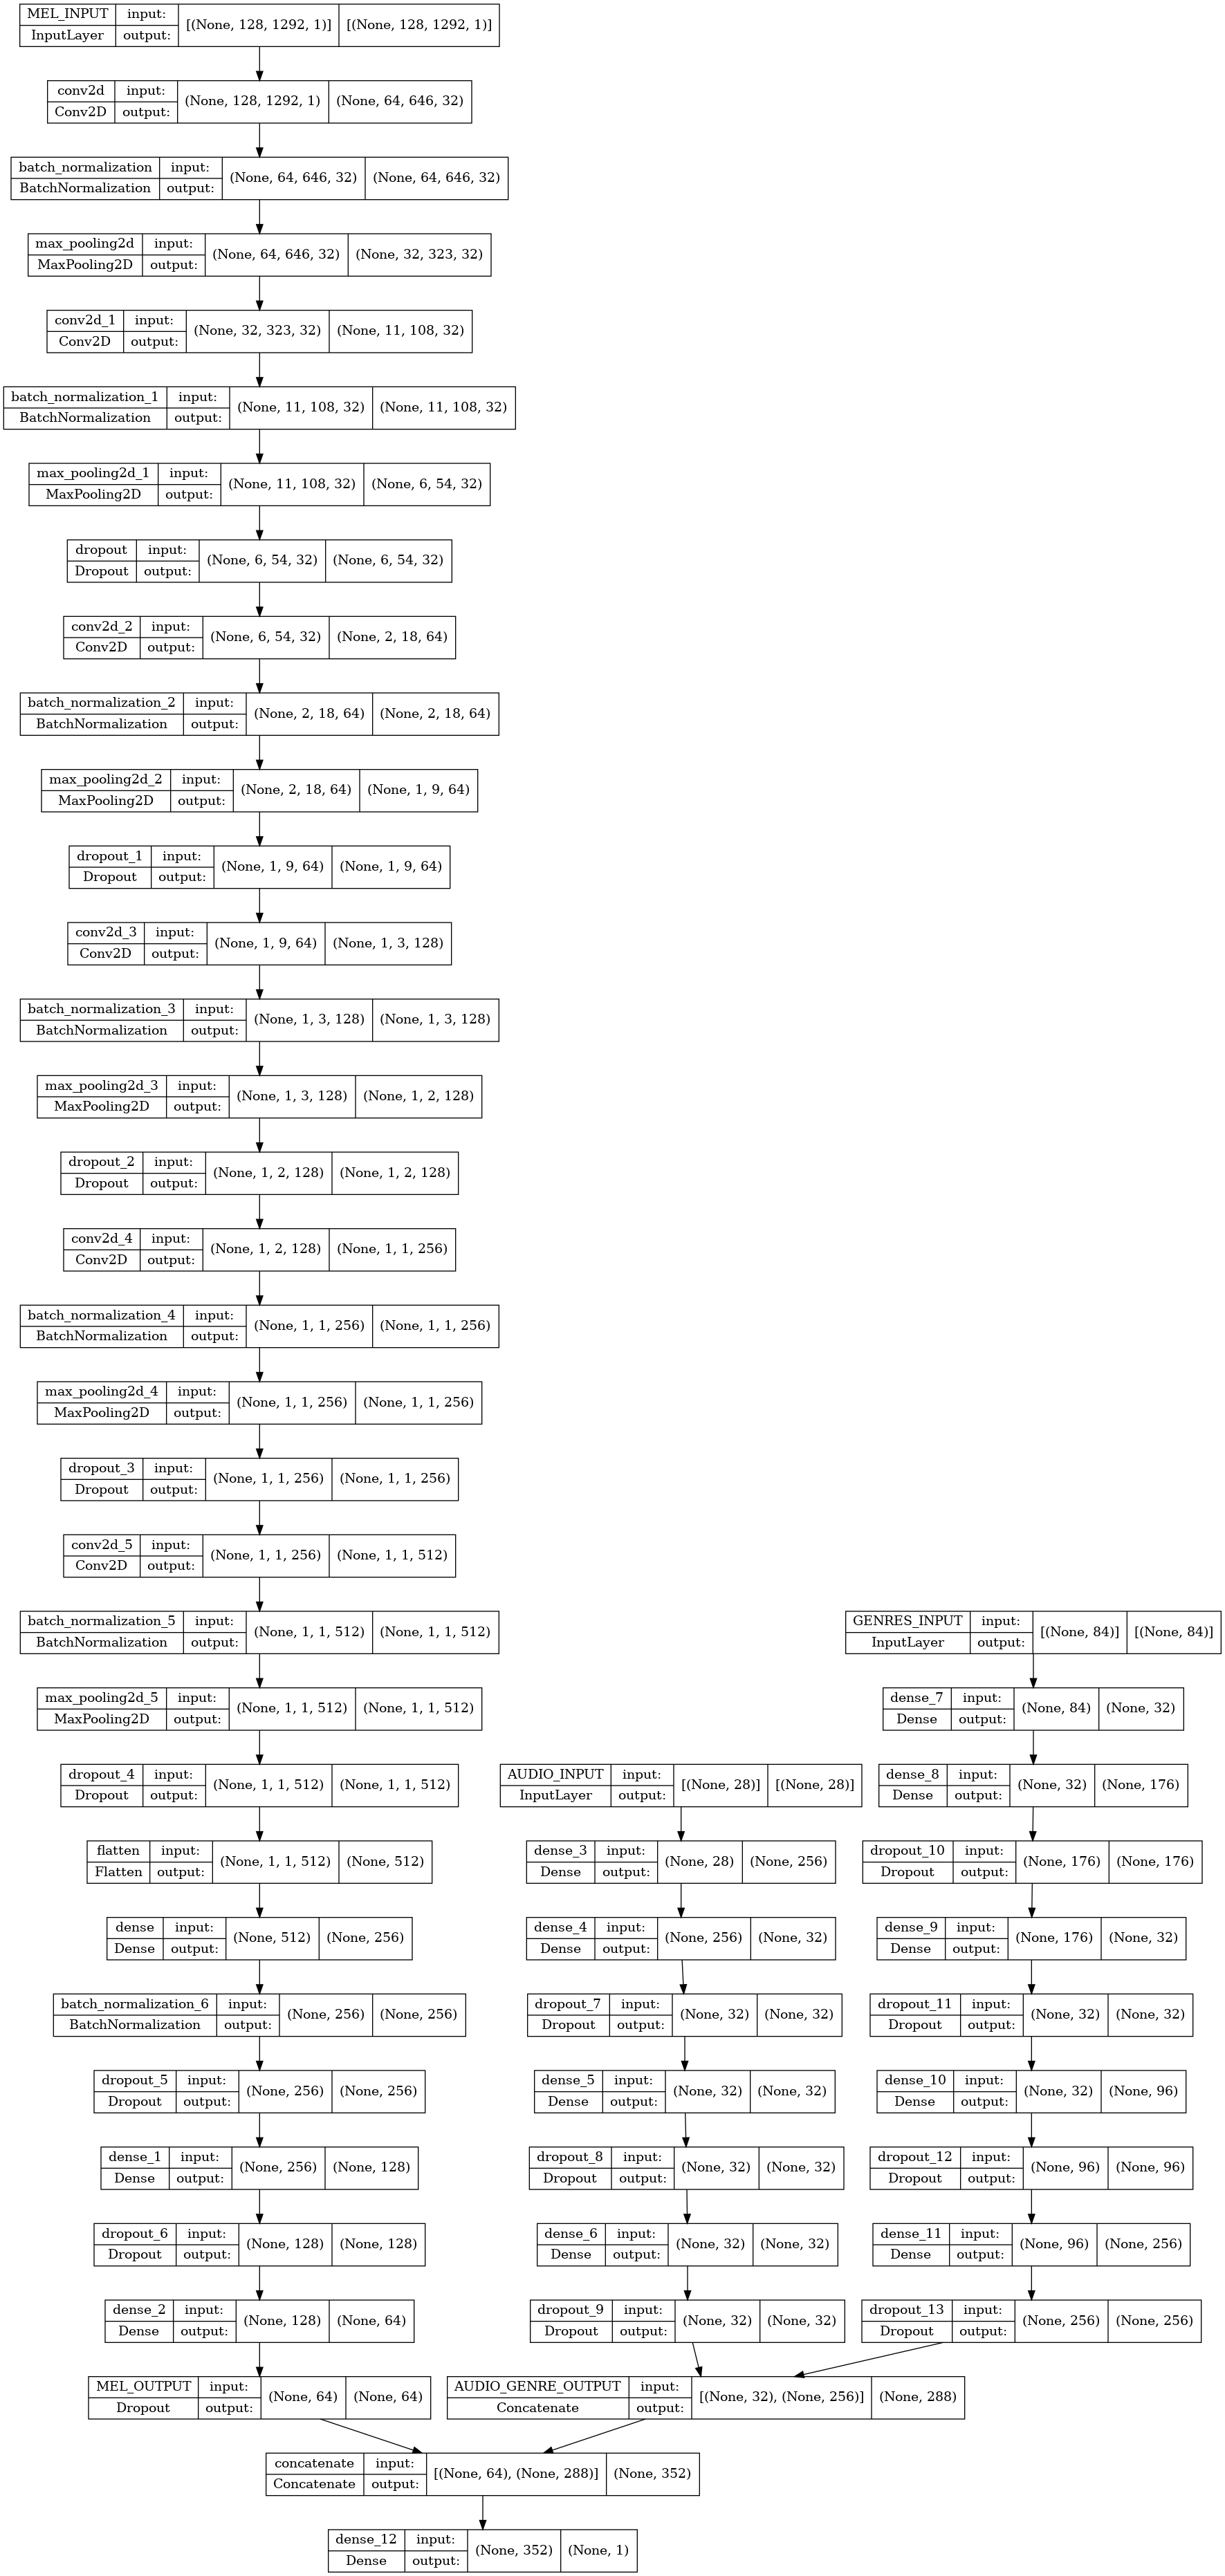

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
checkpoint = ModelCheckpoint(filepath='cnn_before_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

history = model.fit(
            training_generator,
            validation_data=validation_generator,
            epochs=100,
            #steps_per_epoch=len(X_audio_train)/16,
            callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/100
407/407 [==============================] - 10s 22ms/step - loss: 13.7068 - mse: 319.8937 - mae: 14.3825 - val_loss: 13.3513 - val_mse: 304.1650 - val_mae: 14.0269 - lr: 0.0010
Epoch 2/100
407/407 [==============================] - 9s 22ms/step - loss: 12.6512 - mse: 264.6941 - mae: 13.3269 - val_loss: 13.2510 - val_mse: 298.8818 - val_mae: 13.9274 - lr: 0.0010
Epoch 3/100
407/407 [==============================] - 8s 20ms/step - loss: 12.5724 - mse: 261.1396 - mae: 13.2484 - val_loss: 13.7879 - val_mse: 325.5741 - val_mae: 14.4619 - lr: 0.0010
Epoch 4/100
407/407 [==============================] - 8s 20ms/step - loss: 12.6282 - mse: 265.2150 - mae: 13.3036 - val_loss: 12.6286 - val_mse: 267.7518 - val_mae: 13.3040 - lr: 0.0010
Epoch 5/100
407/407 [==============================] - 8s 20ms/step - loss: 12.5547 - mse: 261.1367 - mae: 13.2301 - val_loss: 12.8201 - val_mse: 277.2305 - val_mae: 13.4966 - lr: 0.0010
Epoch 6/100
407/407 [==============================] - 8s 21ms/s

Epoch 45/100
407/407 [==============================] - 9s 21ms/step - loss: 12.0872 - mse: 244.5252 - mae: 12.7617 - val_loss: 12.8086 - val_mse: 274.4118 - val_mae: 13.4858 - lr: 1.0000e-04
Epoch 46/100
407/407 [==============================] - 8s 21ms/step - loss: 12.0735 - mse: 243.7329 - mae: 12.7471 - val_loss: 12.8339 - val_mse: 275.7051 - val_mae: 13.5110 - lr: 1.0000e-04
Epoch 47/100
407/407 [==============================] - 8s 21ms/step - loss: 12.0690 - mse: 243.8376 - mae: 12.7433 - val_loss: 12.8588 - val_mse: 276.6951 - val_mae: 13.5358 - lr: 1.0000e-04
Epoch 48/100
407/407 [==============================] - 8s 20ms/step - loss: 12.0775 - mse: 244.3175 - mae: 12.7518 - val_loss: 12.9208 - val_mse: 279.7397 - val_mae: 13.5979 - lr: 1.0000e-04
Epoch 49/100
407/407 [==============================] - 9s 23ms/step - loss: 12.0473 - mse: 243.9121 - mae: 12.7212 - val_loss: 12.8271 - val_mse: 274.9761 - val_mae: 13.5044 - lr: 1.0000e-04
Epoch 50/100
407/407 [==================

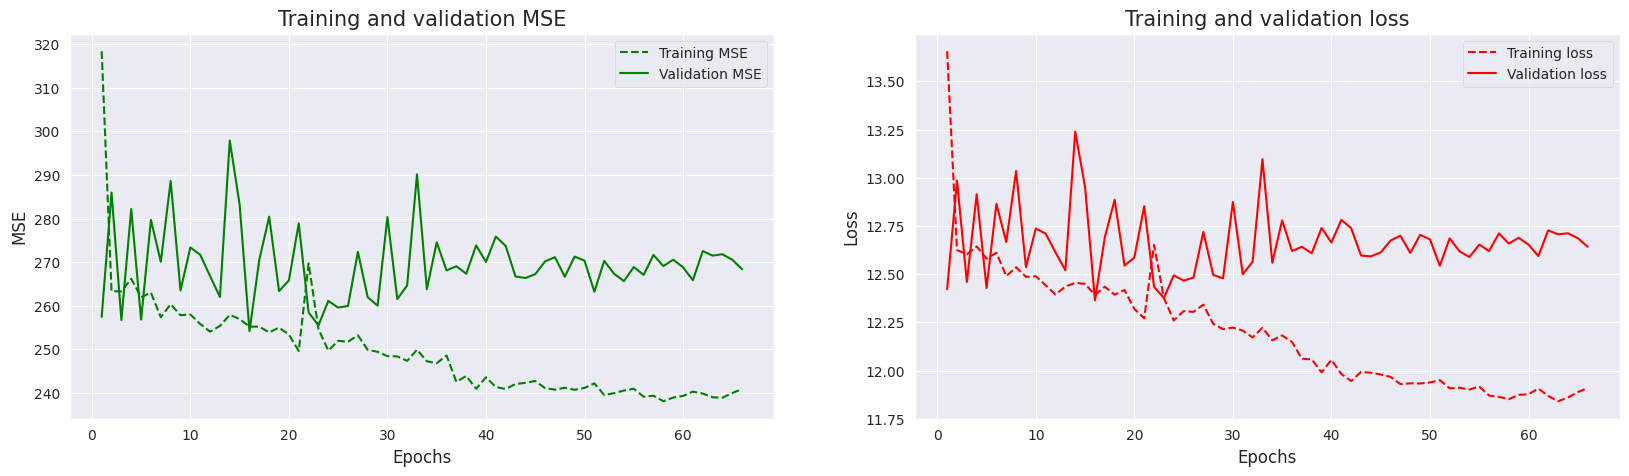

In [26]:
plot_learning_curves(history.history)

In [28]:
#transfer_model = tf.keras.models.load_model('saved_transfer_model/my_model')
model.load_weights("cnn_before_model.h5")
print(model.evaluate(testing_generator))

predictions = model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mel_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mel_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

metric = RSquare()
metric.update_state(y_pre_test, predictions)
result = metric.result()
R2 = result.numpy()

cnn_mel_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mel_mae}\nMSE: {cnn_mel_mse}\nSpearman's Correlation: {cnn_mel_sp[0]}\nR Squared: {R2}")

73/73 [==============================] - 1s 14ms/step - loss: 14.4993 - mse: 335.2845 - mae: 15.1747
[14.499309539794922, 335.2845458984375, 15.1747465133667]
MAE: 15.191780821917808
MSE: 334.3679060665362
Spearman's Correlation: 0.02885080760739216
R Squared: 0.0035271048545837402


In [19]:
print(model.evaluate(testing_generator))

predictions = model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

cnn_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mae}\nMSE: {cnn_mse}\nSpearman's Correlation {cnn_sp[0]}")

/tmp/ipykernel_73595/1563351537.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = self.labels[[batch_indices]]


73/73 [==============================] - 2s 24ms/step - loss: 15.3866 - mse: 388.6823 - mae: 16.0672
[15.386560440063477, 388.6822509765625, 16.067171096801758]
10/73 [===>..........................] - ETA: 0s

/tmp/ipykernel_73595/1563351537.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = self.labels[[batch_indices]]


73/73 [==============================] - 1s 13ms/step
MAE: 16.05675146771037
MSE: 388.3013698630137
Spearman's Correlation 0.08517049024111711


#### VGG16  

In [12]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 1292, 3))

vgg_model.trainable = False

2022-11-16 13:22:29.671955: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 13:22:29.675800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 13:22:29.675998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 13:22:29.676146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [13]:
def cnn_before_model():
    
    audio_input = Input(shape= (X_audio_train.shape[1:]), name="AUDIO_INPUT")
    genres_input = Input(shape=(X_genres_train.shape[1:]), name="GENRES_INPUT")
    
    #Spectrograms
    x = vgg_model.output
    x = Flatten()(x) # Flatten dimensions to for use in FC layers
    x = Dense(64, activation='relu')(x)
    mel_out = Dropout(0.4,  name="MEL_OUTPUT")(x) # Dropout layer to reduce overfitting
    
    hidden_layer = Dense(256, activation = 'swish')(audio_input)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    y = Dropout(0.4)(hidden_layer)
    
    hidden_layer = Dense(32, activation = 'swish')(genres_input)
    hidden_layer = Dense(176, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(96, activation = 'selu')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(256, activation = 'relu')(dropout)
    e = Dropout(0.6)(hidden_layer)
    
    audio_genres_out = Concatenate(axis=1, name="AUDIO_GENRE_OUTPUT")([y, e])
    
    #Combined inputs are passed through a final MLP network
    embeddings = Concatenate(axis=1, name='embeddings')([mel_out, audio_genres_out]) #64+64 = 128-D embedding representation for every song
    print(embeddings.shape)
    
    out = Dense(1)(embeddings)

    model = Model(inputs=[vgg_model.input, audio_input, genres_input], outputs=out)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [14]:
keras.backend.clear_session()
model = cnn_before_model()

(None, 352)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 1292,   0           []                               
                                3)]                                                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 1292, 6  1792        ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 1292, 6  36928       ['block1_conv1[0][0]']           
                                4)                                                

                                                                                                  
 dense_4 (Dense)                (None, 32)           1056        ['dropout_1[0][0]']              
                                                                                                  
 dense_9 (Dense)                (None, 256)          24832       ['dropout_5[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 64)           5242944     ['flatten[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 32)           0           ['dense_4[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 256)          0           ['dense_9[0][0]']                
          

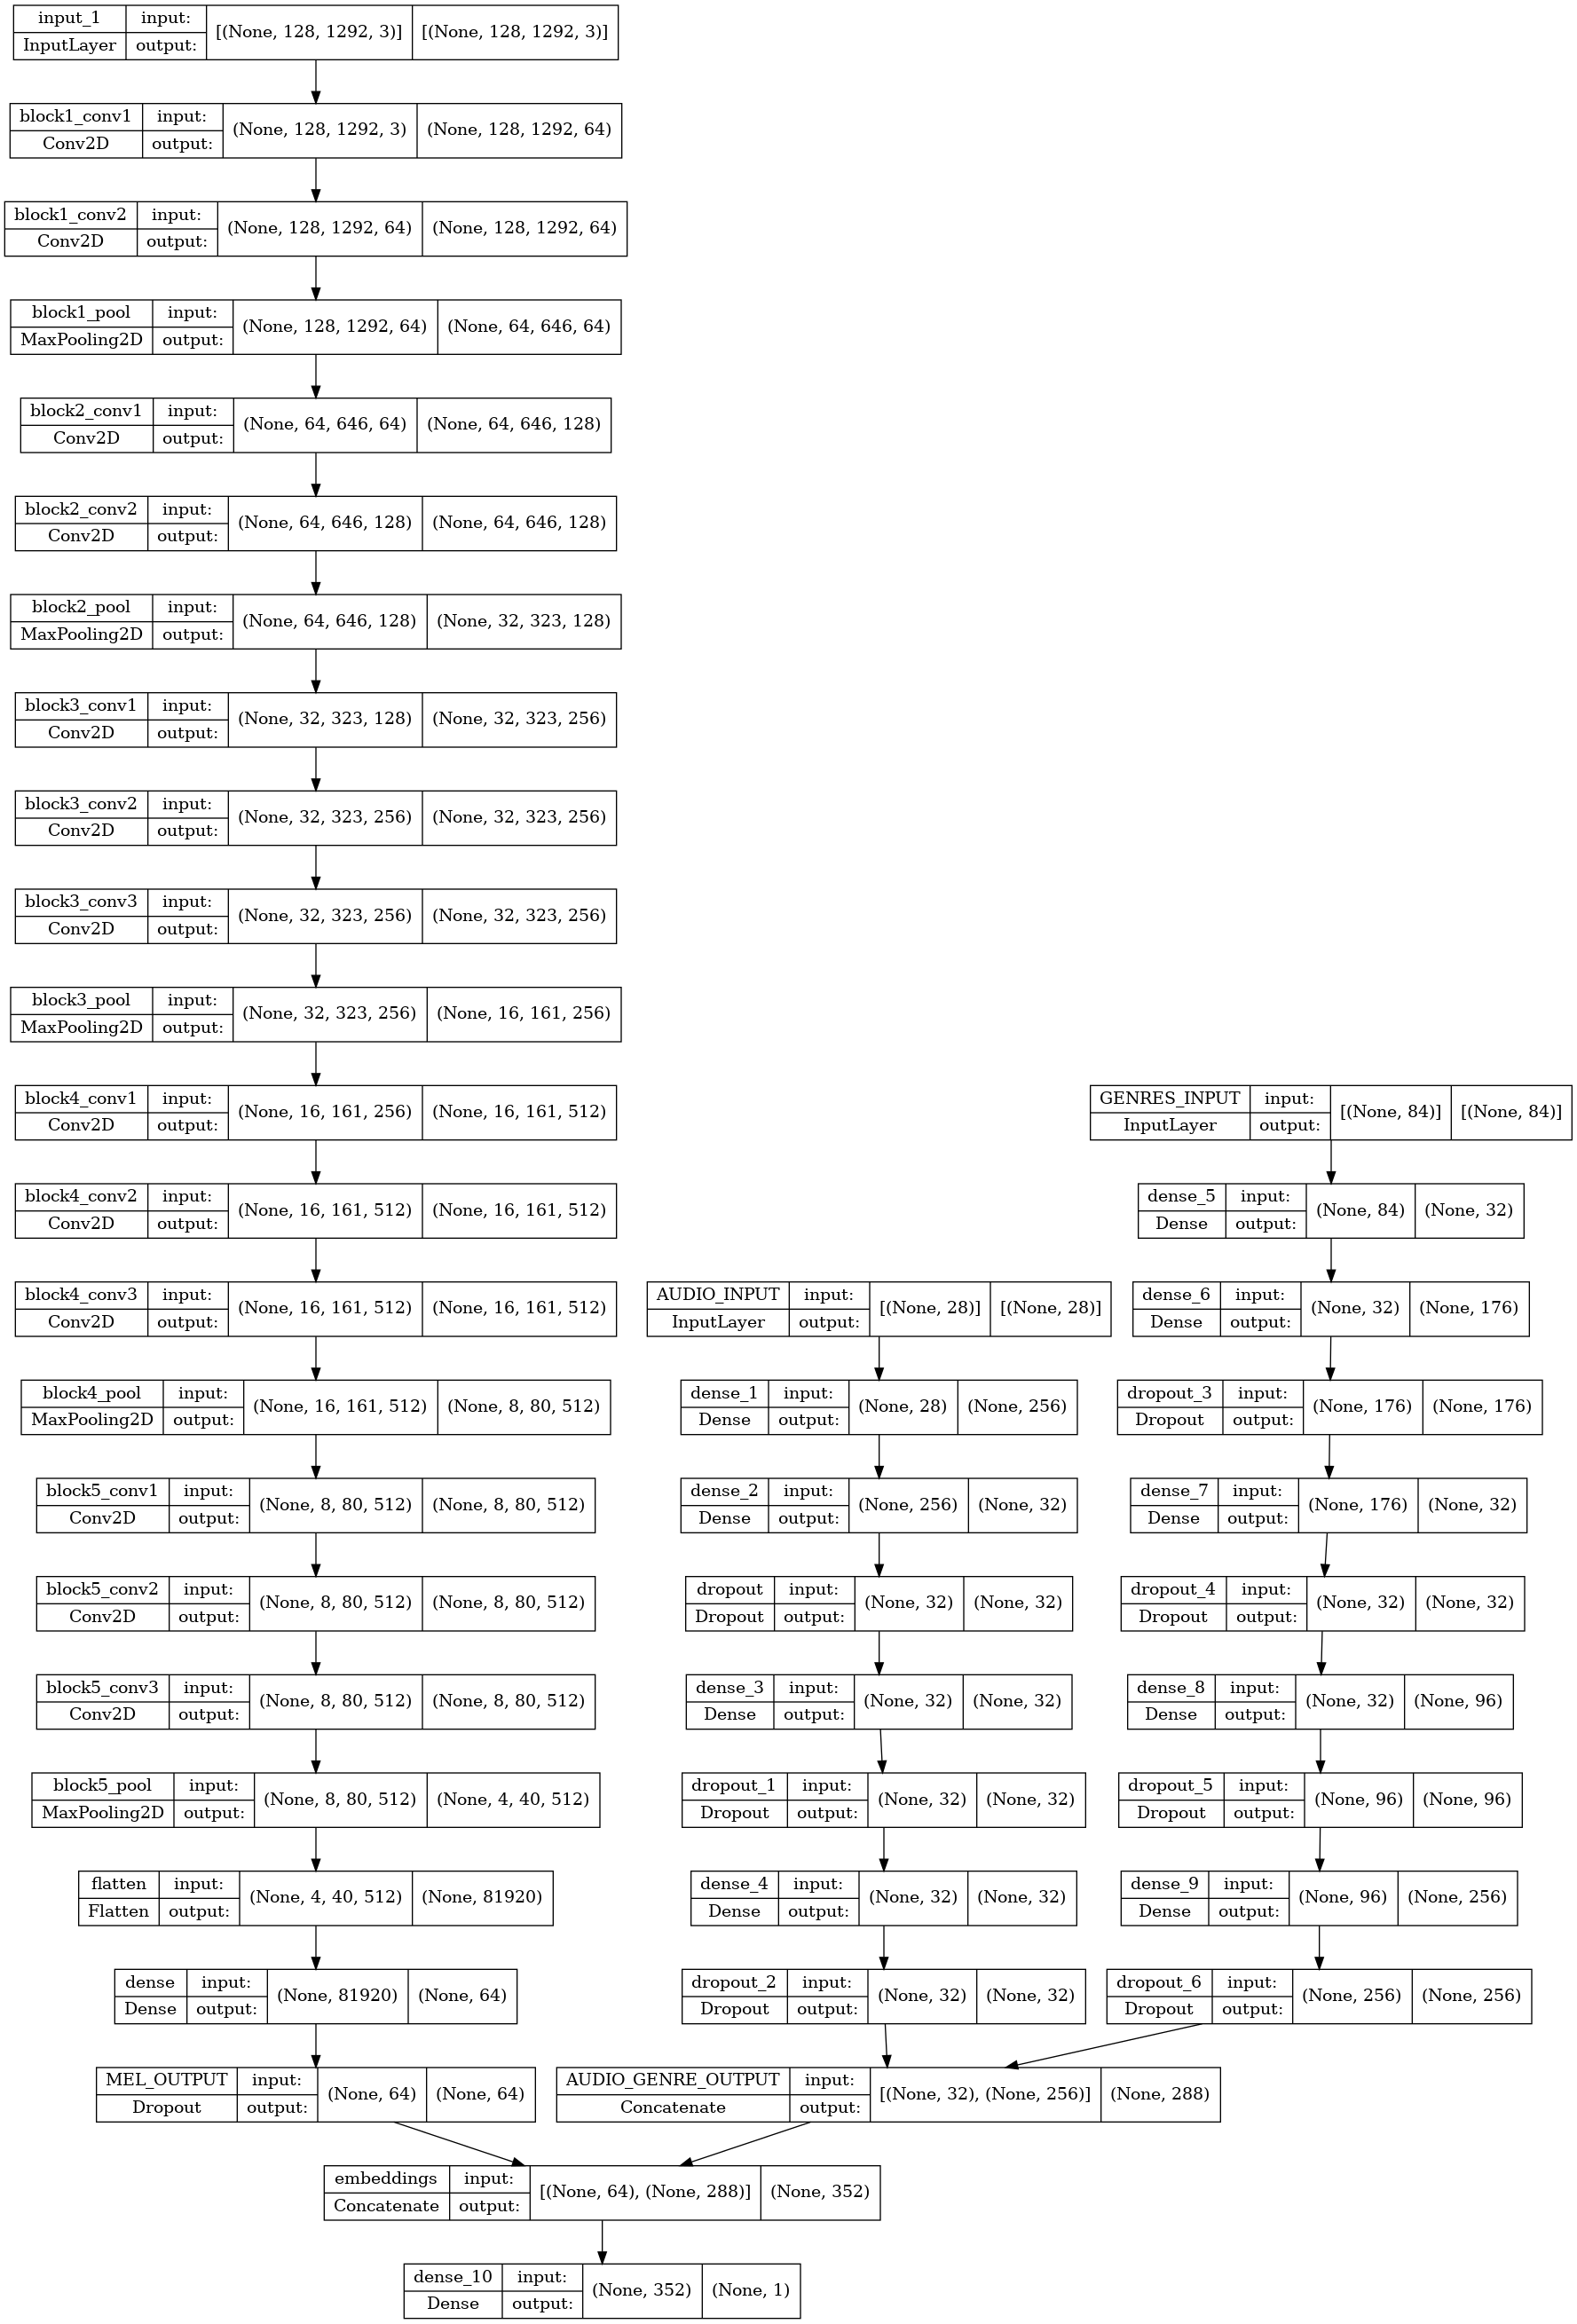

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
checkpoint = ModelCheckpoint(filepath='cnn_before_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(
            training_generator,
            validation_data=validation_generator,
            epochs=40,
            #steps_per_epoch=len(X_audio_train)/16,
            callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/40


2022-11-16 13:23:06.697131: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-16 13:23:06.837590: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


407/407 [==============================] - 113s 259ms/step - loss: 13.7466 - mse: 315.9918 - mae: 14.4231 - val_loss: 12.7419 - val_mse: 274.1101 - val_mae: 13.4183 - lr: 1.0000e-04
Epoch 2/40
407/407 [==============================] - 103s 254ms/step - loss: 12.8540 - mse: 275.6843 - mae: 13.5296 - val_loss: 12.3623 - val_mse: 254.5469 - val_mae: 13.0377 - lr: 1.0000e-04
Epoch 3/40
407/407 [==============================] - 103s 253ms/step - loss: 12.7915 - mse: 272.1220 - mae: 13.4669 - val_loss: 12.4604 - val_mse: 260.1534 - val_mae: 13.1346 - lr: 1.0000e-04
Epoch 4/40
407/407 [==============================] - 103s 253ms/step - loss: 12.7623 - mse: 270.5370 - mae: 13.4383 - val_loss: 12.3931 - val_mse: 256.7254 - val_mae: 13.0679 - lr: 1.0000e-04
Epoch 5/40
407/407 [==============================] - 103s 253ms/step - loss: 12.7521 - mse: 271.8023 - mae: 13.4275 - val_loss: 12.3931 - val_mse: 256.5542 - val_mae: 13.0683 - lr: 1.0000e-04
Epoch 6/40
407/407 [==========================

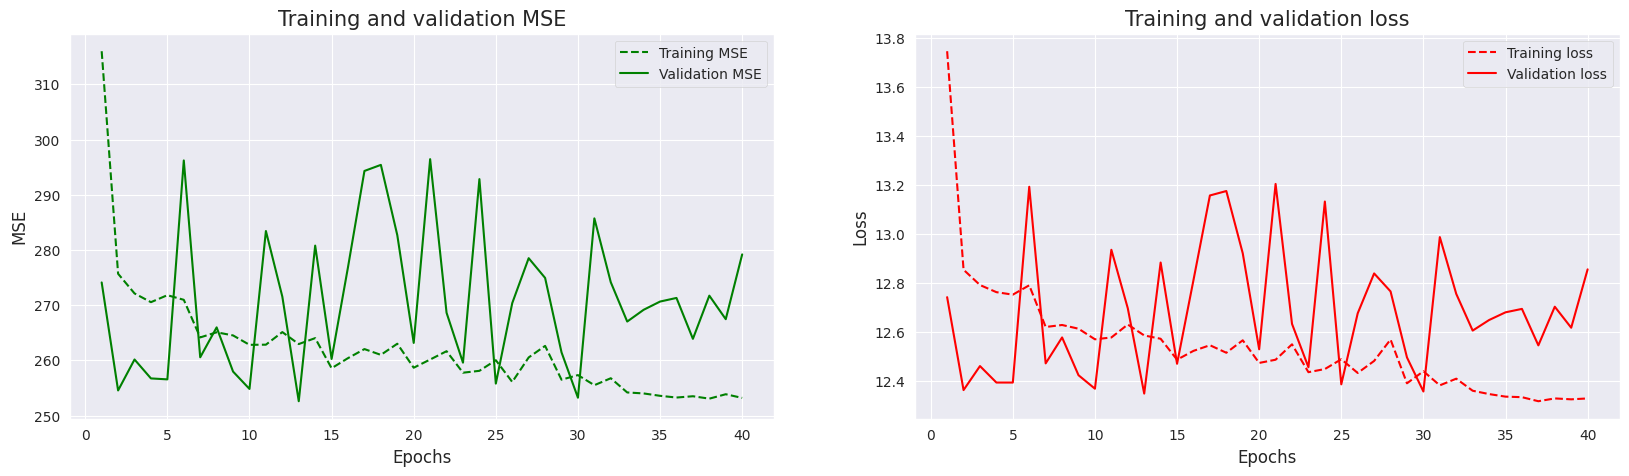

In [17]:
plot_learning_curves(history.history)

In [18]:
#transfer_model = tf.keras.models.load_model('saved_transfer_model/my_model')
model.load_weights("cnn_before_model.h5")
print(model.evaluate(testing_generator))

predictions = model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mel_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mel_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

metric = RSquare()
metric.update_state(y_pre_test, predictions)
result = metric.result()
R2 = result.numpy()

cnn_mel_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mel_mae}\nMSE: {cnn_mel_mse}\nSpearman's Correlation: {cnn_mel_sp[0]}\nR Squared: {R2}")

73/73 [==============================] - 12s 132ms/step - loss: 14.6195 - mse: 338.4531 - mae: 15.2935
[14.619489669799805, 338.45306396484375, 15.293549537658691]
MAE: 15.17123287671233
MSE: 333.5156555772994
Spearman's Correlation: 0.14061406831312176
R Squared: 0.0060669779777526855


In [16]:
model.load_weights("cnn_before_model.h5")
print(model.evaluate(testing_generator))

predictions = model.predict(testing_generator).flatten().round(0).astype(int)

cnn_mae = mean_absolute_error(y_pre_test, predictions)
cnn_mse = mean_squared_error(y_pre_test, predictions)

temp = pd.DataFrame(model.predict(testing_generator).flatten().round(0).astype(int), index=y_pre_test.index)
true_ranks = y_pre_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

cnn_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {cnn_mae}\nMSE: {cnn_mse}\nSpearman's Correlation {cnn_sp[0]}")

/tmp/ipykernel_103311/4240006744.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = self.labels[[batch_indices]]


73/73 [==============================] - 11s 133ms/step - loss: 14.9604 - mse: 368.5732 - mae: 15.6339
[14.960427284240723, 368.5732421875, 15.633899688720703]
 1/73 [..............................] - ETA: 5s

/tmp/ipykernel_103311/4240006744.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = self.labels[[batch_indices]]


73/73 [==============================] - 10s 132ms/step
MAE: 15.619373776908024
MSE: 368.1594911937378
Spearman's Correlation 0.05586336833807646


In [ ]:
MAE: 17.49119373776908
MSE: 493.37181996086105
Spearman's Correlation 0.1895900265364668
#I should keep both overfitting - spearman trade-off

## After Song Release

### Data Generator 

In [79]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
#https://stackoverflow.com/questions/64524078/python-cant-apply-fit-generator-to-keras-model-with-multiple-input
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, all_inds, list_IDs, labels, audio, genre, views, batch_size=16, dim=(128, 1292), n_channels=1, 
                 n_classes, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.all_inds = all_inds
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
        self.audio = audio
        self.genre = genre
        self.views = views
        #self.n = 0
        #self.max = self.__len__()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        batch_indices = [self.all_inds[k] for k in indexes]

        # Generate data
        mel = self.__data_generation1(list_IDs_temp)
        audio, genre, views, y = self.__data_generation2(batch_indices)

        X = [mel, audio, genre, views]
        
        return X, y #{'audio':audio,'genre':genre,'views':views},y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __data_generation1(self, list_IDs_temp):
        # Initialization
        mel = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            mel[i] = np.load(os.getcwd() + '/mfccs/' + ID + '.npy')
            mel[i] = librosa.util.normalize(mel[i])

            # Store class
            #y[i] = self.labels[ID]
        
        mel = np.repeat(mel[:, :, :, np.newaxis], 3, -1)
        
        return mel
        
    def __data_generation2(self, batch_indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
           
        # Generate data
        audio = self.audio[batch_indices,:]
        # note that you need to stack the slice in order to reshape it to (num_samples,768)
        genre = self.genre[batch_indices,:] #np.stack(self.genre[batch_indices])
        # since batch_size is not a super large number, you can stack here
        #views = self.views[batch_indices,:,:] #np.stack([fn2img(seed) for seed in self.views[batch_indices]])
        views = np.stack(self.views[batch_indices,:,:])
        y = self.labels[[batch_indices]]

        return audio, genre, views, y
    
        
        #return mel #, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

In [80]:
#Batch Size needs to match data exactly.
#Audio
y_pretrained = pd.concat([y_train, y_val, y_test])
y_pre_train = y_pretrained.iloc[:int(y_pretrained.shape[0] * 0.795)] #keep 80% of sorted data as train
y_pre_val = y_pretrained.iloc[int(y_pretrained.shape[0] * 0.795):int(y_pretrained.shape[0] * 0.905)] # 10% validation 
y_pre_test = y_pretrained.iloc[int(y_pretrained.shape[0] * 0.905):] # 10% test
print(y_pre_train.shape, y_pre_val.shape, y_pre_test.shape)

(8547,) (1183,) (1022,)


In [81]:
# Datasets
partition = {'train': list(y_pre_train.index), 'validation': list(y_pre_val.index), 'test': list(y_pre_test.index)}
labels = pd.concat([y_pre_train, y_pre_val, y_pre_test]).to_dict()

# Parameters
params = {'dim': (128, 1292),
          'batch_size': 21,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}

# Generators
training_generator = DataGenerator([i for i in range(0, len(y_pre_train))], partition['train'], y_pre_train.values,  X_audio_train.values, X_genres_train.values, X_views_train, **params)

params = {'dim': (128, 1292),
          'batch_size': 13,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}
validation_generator = DataGenerator([i for i in range(0, len(y_pre_val))], partition['validation'], y_pre_val.values,  X_audio_train.values, X_genres_train.values, X_views_val, **params)

params = {'dim': (128, 1292),
          'batch_size': 14,
          'n_classes': 84,
          'n_channels': 1,
          'shuffle': False}
testing_generator = DataGenerator([i for i in range(0, len(y_pre_test))], partition['test'], y_pre_test.values, X_audio_train.values, X_genres_train.values, X_views_test, **params)

In [82]:
for x in testing_generator:
    print(x)

/tmp/ipykernel_172253/312765110.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = self.labels[[batch_indices]]


([array([[[[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.2330097 ,  0.2330097 ,  0.2330097 ],
         [ 0.08356441,  0.08356441,  0.08356441],
         [ 0.27618057,  0.27618057,  0.27618057]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.68885951,  0.68885951,  0.68885951],
         [ 0.71044593,  0.71044593,  0.71044593],
         [ 0.67776912,  0.67776912,  0.67776912]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.79810218,  0.79810218,  0.79810218],
         [ 0.8191458 ,  0.8191458 ,  0.8191458 ],
         [ 0.78468341,  0.78468341,  0.78468341]],

        ...,

        [[-1.        , -1.        , 

([array([[[[-0.50302945, -0.50302945, -0.50302945],
         [-0.71802241, -0.71802241, -0.71802241],
         [-0.68963258, -0.68963258, -0.68963258],
         ...,
         [ 0.66140614,  0.66140614,  0.66140614],
         [ 0.76259793,  0.76259793,  0.76259793],
         [ 0.79467966,  0.79467966,  0.79467966]],

        [[-0.51393994, -0.51393994, -0.51393994],
         [-0.53642813, -0.53642813, -0.53642813],
         [-0.54159793, -0.54159793, -0.54159793],
         ...,
         [ 0.88286951,  0.88286951,  0.88286951],
         [ 0.9112296 ,  0.9112296 ,  0.9112296 ],
         [ 0.91588309,  0.91588309,  0.91588309]],

        [[-0.53806035, -0.53806035, -0.53806035],
         [-0.4781857 , -0.4781857 , -0.4781857 ],
         [-0.48060611, -0.48060611, -0.48060611],
         ...,
         [ 0.97931339,  0.97931339,  0.97931339],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        ...,

        [[-0.76231528, -0.76231528, 

([array([[[[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.02677723, -0.02677723, -0.02677723],
         [-0.0529529 , -0.0529529 , -0.0529529 ],
         [ 0.0220146 ,  0.0220146 ,  0.0220146 ]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.17964243,  0.17964243,  0.17964243],
         [-0.03591926, -0.03591926, -0.03591926],
         [ 0.01351254,  0.01351254,  0.01351254]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.276023  ,  0.276023  ,  0.276023  ],
         [-0.01015368, -0.01015368, -0.01015368],
         [ 0.00165518,  0.00165518,  0.00165518]],

        ...,

        [[-1.        , -1.        , 

([array([[[[-0.3773535 , -0.3773535 , -0.3773535 ],
         [-0.44107434, -0.44107434, -0.44107434],
         [-0.25228874, -0.25228874, -0.25228874],
         ...,
         [-0.44786651, -0.44786651, -0.44786651],
         [-0.14385213, -0.14385213, -0.14385213],
         [-0.01573924, -0.01573924, -0.01573924]],

        [[-0.25211868, -0.25211868, -0.25211868],
         [-0.43649884, -0.43649884, -0.43649884],
         [-0.23454182, -0.23454182, -0.23454182],
         ...,
         [-0.42347506, -0.42347506, -0.42347506],
         [-0.02717632, -0.02717632, -0.02717632],
         [ 0.11755118,  0.11755118,  0.11755118]],

        [[-0.1912225 , -0.1912225 , -0.1912225 ],
         [-0.42810107, -0.42810107, -0.42810107],
         [-0.21018929, -0.21018929, -0.21018929],
         ...,
         [-0.38835576, -0.38835576, -0.38835576],
         [ 0.06209996,  0.06209996,  0.06209996],
         [ 0.21089835,  0.21089835,  0.21089835]],

        ...,

        [[-0.91429728, -0.91429728, 

([array([[[[-0.46959121, -0.46959121, -0.46959121],
         [-0.8217874 , -0.8217874 , -0.8217874 ],
         [-0.90787221, -0.90787221, -0.90787221],
         ...,
         [ 0.99633348,  0.99633348,  0.99633348],
         [ 0.99599101,  0.99599101,  0.99599101],
         [ 0.98464232,  0.98464232,  0.98464232]],

        [[-0.49066866, -0.49066866, -0.49066866],
         [-0.85118292, -0.85118292, -0.85118292],
         [-0.8507386 , -0.8507386 , -0.8507386 ],
         ...,
         [ 0.99685855,  0.99685855,  0.99685855],
         [ 0.99664804,  0.99664804,  0.99664804],
         [ 0.9897451 ,  0.9897451 ,  0.9897451 ]],

        [[-0.54221785, -0.54221785, -0.54221785],
         [-1.        , -1.        , -1.        ],
         [-0.80398956, -0.80398956, -0.80398956],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        ...,

        [[-0.9513198 , -0.9513198 , 

([array([[[[-0.30042682, -0.30042682, -0.30042682],
         [ 0.04143303,  0.04143303,  0.04143303],
         [-0.15494969, -0.15494969, -0.15494969],
         ...,
         [-0.73825054, -0.73825054, -0.73825054],
         [-0.96048308, -0.96048308, -0.96048308],
         [-0.83441512, -0.83441512, -0.83441512]],

        [[-0.18063655, -0.18063655, -0.18063655],
         [ 0.00967123,  0.00967123,  0.00967123],
         [-0.06000256, -0.06000256, -0.06000256],
         ...,
         [-0.72575619, -0.72575619, -0.72575619],
         [-0.93903633, -0.93903633, -0.93903633],
         [-0.76542411, -0.76542411, -0.76542411]],

        [[-0.11880037, -0.11880037, -0.11880037],
         [-0.08578589, -0.08578589, -0.08578589],
         [ 0.02424499,  0.02424499,  0.02424499],
         ...,
         [-0.70194214, -0.70194214, -0.70194214],
         [-0.90384459, -0.90384459, -0.90384459],
         [-0.68706584, -0.68706584, -0.68706584]],

        ...,

        [[-0.91759093, -0.91759093, 

([array([[[[-8.99328197e-01, -8.99328197e-01, -8.99328197e-01],
         [-9.09484187e-01, -9.09484187e-01, -9.09484187e-01],
         [-9.79626027e-01, -9.79626027e-01, -9.79626027e-01],
         ...,
         [ 1.26651752e-01,  1.26651752e-01,  1.26651752e-01],
         [ 6.58277184e-02,  6.58277184e-02,  6.58277184e-02],
         [ 5.78847485e-02,  5.78847485e-02,  5.78847485e-02]],

        [[-9.05126359e-01, -9.05126359e-01, -9.05126359e-01],
         [-8.94941172e-01, -8.94941172e-01, -8.94941172e-01],
         [-9.86636583e-01, -9.86636583e-01, -9.86636583e-01],
         ...,
         [ 4.16693533e-01,  4.16693533e-01,  4.16693533e-01],
         [ 3.11618931e-01,  3.11618931e-01,  3.11618931e-01],
         [ 3.11827962e-01,  3.11827962e-01,  3.11827962e-01]],

        [[-9.15637067e-01, -9.15637067e-01, -9.15637067e-01],
         [-8.76471244e-01, -8.76471244e-01, -8.76471244e-01],
         [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
         ...,
         [ 5.25271186e

([array([[[[-0.51814817, -0.51814817, -0.51814817],
         [-0.53558356, -0.53558356, -0.53558356],
         [-0.55576361, -0.55576361, -0.55576361],
         ...,
         [-0.54664042, -0.54664042, -0.54664042],
         [-0.44601331, -0.44601331, -0.44601331],
         [-0.41961337, -0.41961337, -0.41961337]],

        [[-0.53993858, -0.53993858, -0.53993858],
         [-0.5582417 , -0.5582417 , -0.5582417 ],
         [-0.57917526, -0.57917526, -0.57917526],
         ...,
         [-0.35394861, -0.35394861, -0.35394861],
         [-0.3859779 , -0.3859779 , -0.3859779 ],
         [-0.42707575, -0.42707575, -0.42707575]],

        [[-0.8921382 , -0.8921382 , -0.8921382 ],
         [-0.88165381, -0.88165381, -0.88165381],
         [-0.95210146, -0.95210146, -0.95210146],
         ...,
         [-0.26671131, -0.26671131, -0.26671131],
         [-0.32834706, -0.32834706, -0.32834706],
         [-0.43910397, -0.43910397, -0.43910397]],

        ...,

        [[-0.77442518, -0.77442518, 

([array([[[[-9.29113046e-01, -9.29113046e-01, -9.29113046e-01],
         [-9.71538272e-01, -9.71538272e-01, -9.71538272e-01],
         [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
         ...,
         [-7.18817089e-01, -7.18817089e-01, -7.18817089e-01],
         [-8.76608209e-01, -8.76608209e-01, -8.76608209e-01],
         [-8.25920988e-01, -8.25920988e-01, -8.25920988e-01]],

        [[-7.49483840e-01, -7.49483840e-01, -7.49483840e-01],
         [-7.86369572e-01, -7.86369572e-01, -7.86369572e-01],
         [-6.93275666e-01, -6.93275666e-01, -6.93275666e-01],
         ...,
         [-7.49751290e-01, -7.49751290e-01, -7.49751290e-01],
         [-8.89109726e-01, -8.89109726e-01, -8.89109726e-01],
         [-8.04168601e-01, -8.04168601e-01, -8.04168601e-01]],

        [[-6.97736994e-01, -6.97736994e-01, -6.97736994e-01],
         [-7.23201366e-01, -7.23201366e-01, -7.23201366e-01],
         [-6.40202418e-01, -6.40202418e-01, -6.40202418e-01],
         ...,
         [-8.49635986e

([array([[[[-0.83043549, -0.83043549, -0.83043549],
         [-0.83512464, -0.83512464, -0.83512464],
         [-0.78321728, -0.78321728, -0.78321728],
         ...,
         [-0.73495346, -0.73495346, -0.73495346],
         [-0.53624667, -0.53624667, -0.53624667],
         [-0.8346963 , -0.8346963 , -0.8346963 ]],

        [[-0.77284378, -0.77284378, -0.77284378],
         [-0.80529277, -0.80529277, -0.80529277],
         [-0.78917022, -0.78917022, -0.78917022],
         ...,
         [-0.78720188, -0.78720188, -0.78720188],
         [-0.57565944, -0.57565944, -0.57565944],
         [-0.65301867, -0.65301867, -0.65301867]],

        [[-0.73738007, -0.73738007, -0.73738007],
         [-0.77707839, -0.77707839, -0.77707839],
         [-0.80029575, -0.80029575, -0.80029575],
         ...,
         [-1.        , -1.        , -1.        ],
         [-0.690122  , -0.690122  , -0.690122  ],
         [-0.49871336, -0.49871336, -0.49871336]],

        ...,

        [[-0.81730995, -0.81730995, 

([array([[[[-0.66468497, -0.66468497, -0.66468497],
         [-0.68075857, -0.68075857, -0.68075857],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.58690586,  0.58690586,  0.58690586],
         [ 0.56629179,  0.56629179,  0.56629179],
         [ 0.61743633,  0.61743633,  0.61743633]],

        [[-0.57058602, -0.57058602, -0.57058602],
         [-0.60979951, -0.60979951, -0.60979951],
         [-0.64044752, -0.64044752, -0.64044752],
         ...,
         [ 0.84156896,  0.84156896,  0.84156896],
         [ 0.87365584,  0.87365584,  0.87365584],
         [ 0.88411513,  0.88411513,  0.88411513]],

        [[-0.52860578, -0.52860578, -0.52860578],
         [-0.5619646 , -0.5619646 , -0.5619646 ],
         [-0.56511308, -0.56511308, -0.56511308],
         ...,
         [ 0.95334277,  0.95334277,  0.95334277],
         [ 0.99180919,  0.99180919,  0.99180919],
         [ 1.        ,  1.        ,  1.        ]],

        ...,

        [[-0.72859806, -0.72859806, 

([array([[[[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.00969297,  0.00969297,  0.00969297],
         [-0.01854434, -0.01854434, -0.01854434],
         [-0.06434095, -0.06434095, -0.06434095]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.12429637,  0.12429637,  0.12429637],
         [ 0.07463174,  0.07463174,  0.07463174],
         [ 0.03880111,  0.03880111,  0.03880111]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [ 0.21137124,  0.21137124,  0.21137124],
         [ 0.15404745,  0.15404745,  0.15404745],
         [ 0.12423098,  0.12423098,  0.12423098]],

        ...,

        [[-1.        , -1.        , 

([array([[[[-0.86883591, -0.86883591, -0.86883591],
         [-0.21624392, -0.21624392, -0.21624392],
         [ 0.0575122 ,  0.0575122 ,  0.0575122 ],
         ...,
         [ 0.78457832,  0.78457832,  0.78457832],
         [ 0.78486921,  0.78486921,  0.78486921],
         [ 0.78282861,  0.78282861,  0.78282861]],

        [[-0.78104675, -0.78104675, -0.78104675],
         [-0.20716775, -0.20716775, -0.20716775],
         [ 0.24370427,  0.24370427,  0.24370427],
         ...,
         [ 0.91505846,  0.91505846,  0.91505846],
         [ 0.91530258,  0.91530258,  0.91530258],
         [ 0.91505759,  0.91505759,  0.91505759]],

        [[-0.74146461, -0.74146461, -0.74146461],
         [-0.19300776, -0.19300776, -0.19300776],
         [ 0.33291387,  0.33291387,  0.33291387],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        ...,

        [[-0.73687004, -0.73687004, 

### Final Model 

In [83]:
# CREATE TWO INPUT MODEL
def cnn_after_model(n_layers = 6, img_height = 128, img_width = 1292, n_channels = 1, n_timesteps = 41, n_features = 2):
    
    mel_input = Input(shape=(img_height, img_width, n_channels), name="MEL_INPUT")
    audio_input = Input(shape=(X_audio_train.shape[1:]), name="AUDIO_INPUT")
    genres_input = Input(shape=(X_genres_train.shape[1:]), name="GENRES_INPUT")
    views_input = Input(shape=(n_timesteps, n_features), name="TIMESERIES_INPUT")
    
    #Mel
    x = vgg_model.output
    x = Flatten()(x) # Flatten dimensions to for use in FC layers
    x = Dense(64, activation='relu')(x)
    mel_out = Dropout(0.4,  name="MEL_OUTPUT")(x) # Dropout layer to reduce overfitting
    
    #Audio & Genres
    y = Dense(128, kernel_regularizer=l2(0.001), activation="relu")(audio_input)
    
    for i in range(n_layers):
        y = Dense(32, kernel_regularizer=l2(0.001), activation="relu")(y)
        y = Dropout(0.5)(y)
        
    e = Dense(208, kernel_regularizer=l2(0.001), activation="relu")(genres_input)
    
    for i in range(n_layers):
        e = Dense(32, kernel_regularizer=l2(0.001), activation="relu")(e)
        e = Dropout(0.5)(e)
    
    combined_1 = Concatenate(axis=1)([y, e])
    ye = Dense(256, activation="relu")(combined_1)
    ye = Dense(256, activation="relu")(ye)
    ye = Dense(32, activation="relu")(ye)
    ye = Dense(32, activation="relu")(ye)
    ye = Dense(32, activation="relu")(ye)
    ye = Dense(256, activation="relu")(ye)
    ye = Dense(208, activation="relu")(ye)
    audio_genres_out = Dense(208, activation="relu", name="AUDIO_GENRE_OUTPUT")(ye)
    
    #Youtube Views
    v = Bidirectional(GRU(32, return_sequences=True))(views_input)
    for i in range(n_layers - 1):
        v = Bidirectional(GRU(64, return_sequences=True))(v)
    
    v = Dropout(0.2)(v)
    v = GlobalAvgPool1D()(v)
    v = Flatten()(v)
    v = Dropout(0.1)(v)
    v = Dense(32,  activation="relu")(v)
    views_out = Dense(32,  activation="relu", name="VIEWS_OUTPUT")(v) 

    #Combine
    combined_2 = Concatenate(axis=1)([mel_out, audio_genres_out])
    z = Dense(64, activation="relu")(combined_2)
    z = Dropout(0.2)(z)
    
    combined_3 = Concatenate(axis=1)([views_out, z])
    z = Dense(64, activation="relu")(combined_3)
    z = Dropout(0.2)(z)
    z = Dense(64, activation="relu")(z)
    z = Dropout(0.2)(z)
    out = Dense(1)(z)

    model = Model(inputs=[vgg_model.input, audio_input, genres_input, views_input], outputs=out)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()
    return model

In [84]:
keras.backend.clear_session()
model = cnn_after_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 AUDIO_INPUT (InputLayer)       [(None, 28)]         0           []                               
                                                                                                  
 GENRES_INPUT (InputLayer)      [(None, 84)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128, 1292,   0           []                               
                                3)]                                                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          3712        ['AUDIO_INPUT[0][0]']        

 block4_conv1 (Conv2D)          (None, 16, 161, 512  1180160     ['block3_pool[0][0]']            
                                )                                                                 
                                                                                                  
 dense_7 (Dense)                (None, 32)           1056        ['dropout_4[0][0]']              
                                                                                                  
 dense_14 (Dense)               (None, 32)           1056        ['dropout_10[0][0]']             
                                                                                                  
 TIMESERIES_INPUT (InputLayer)  [(None, 41, 2)]      0           []                               
                                                                                                  
 block4_conv2 (Conv2D)          (None, 16, 161, 512  2359808     ['block4_conv1[0][0]']           
          

                                                                                                  
 dense_22 (Dense)               (None, 32)           4128        ['dropout_13[0][0]']             
                                                                                                  
 dense_23 (Dense)               (None, 64)           17472       ['concatenate_1[0][0]']          
                                                                                                  
 VIEWS_OUTPUT (Dense)           (None, 32)           1056        ['dense_22[0][0]']               
                                                                                                  
 dropout_14 (Dropout)           (None, 64)           0           ['dense_23[0][0]']               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 96)           0           ['VIEWS_OUTPUT[0][0]',           
          

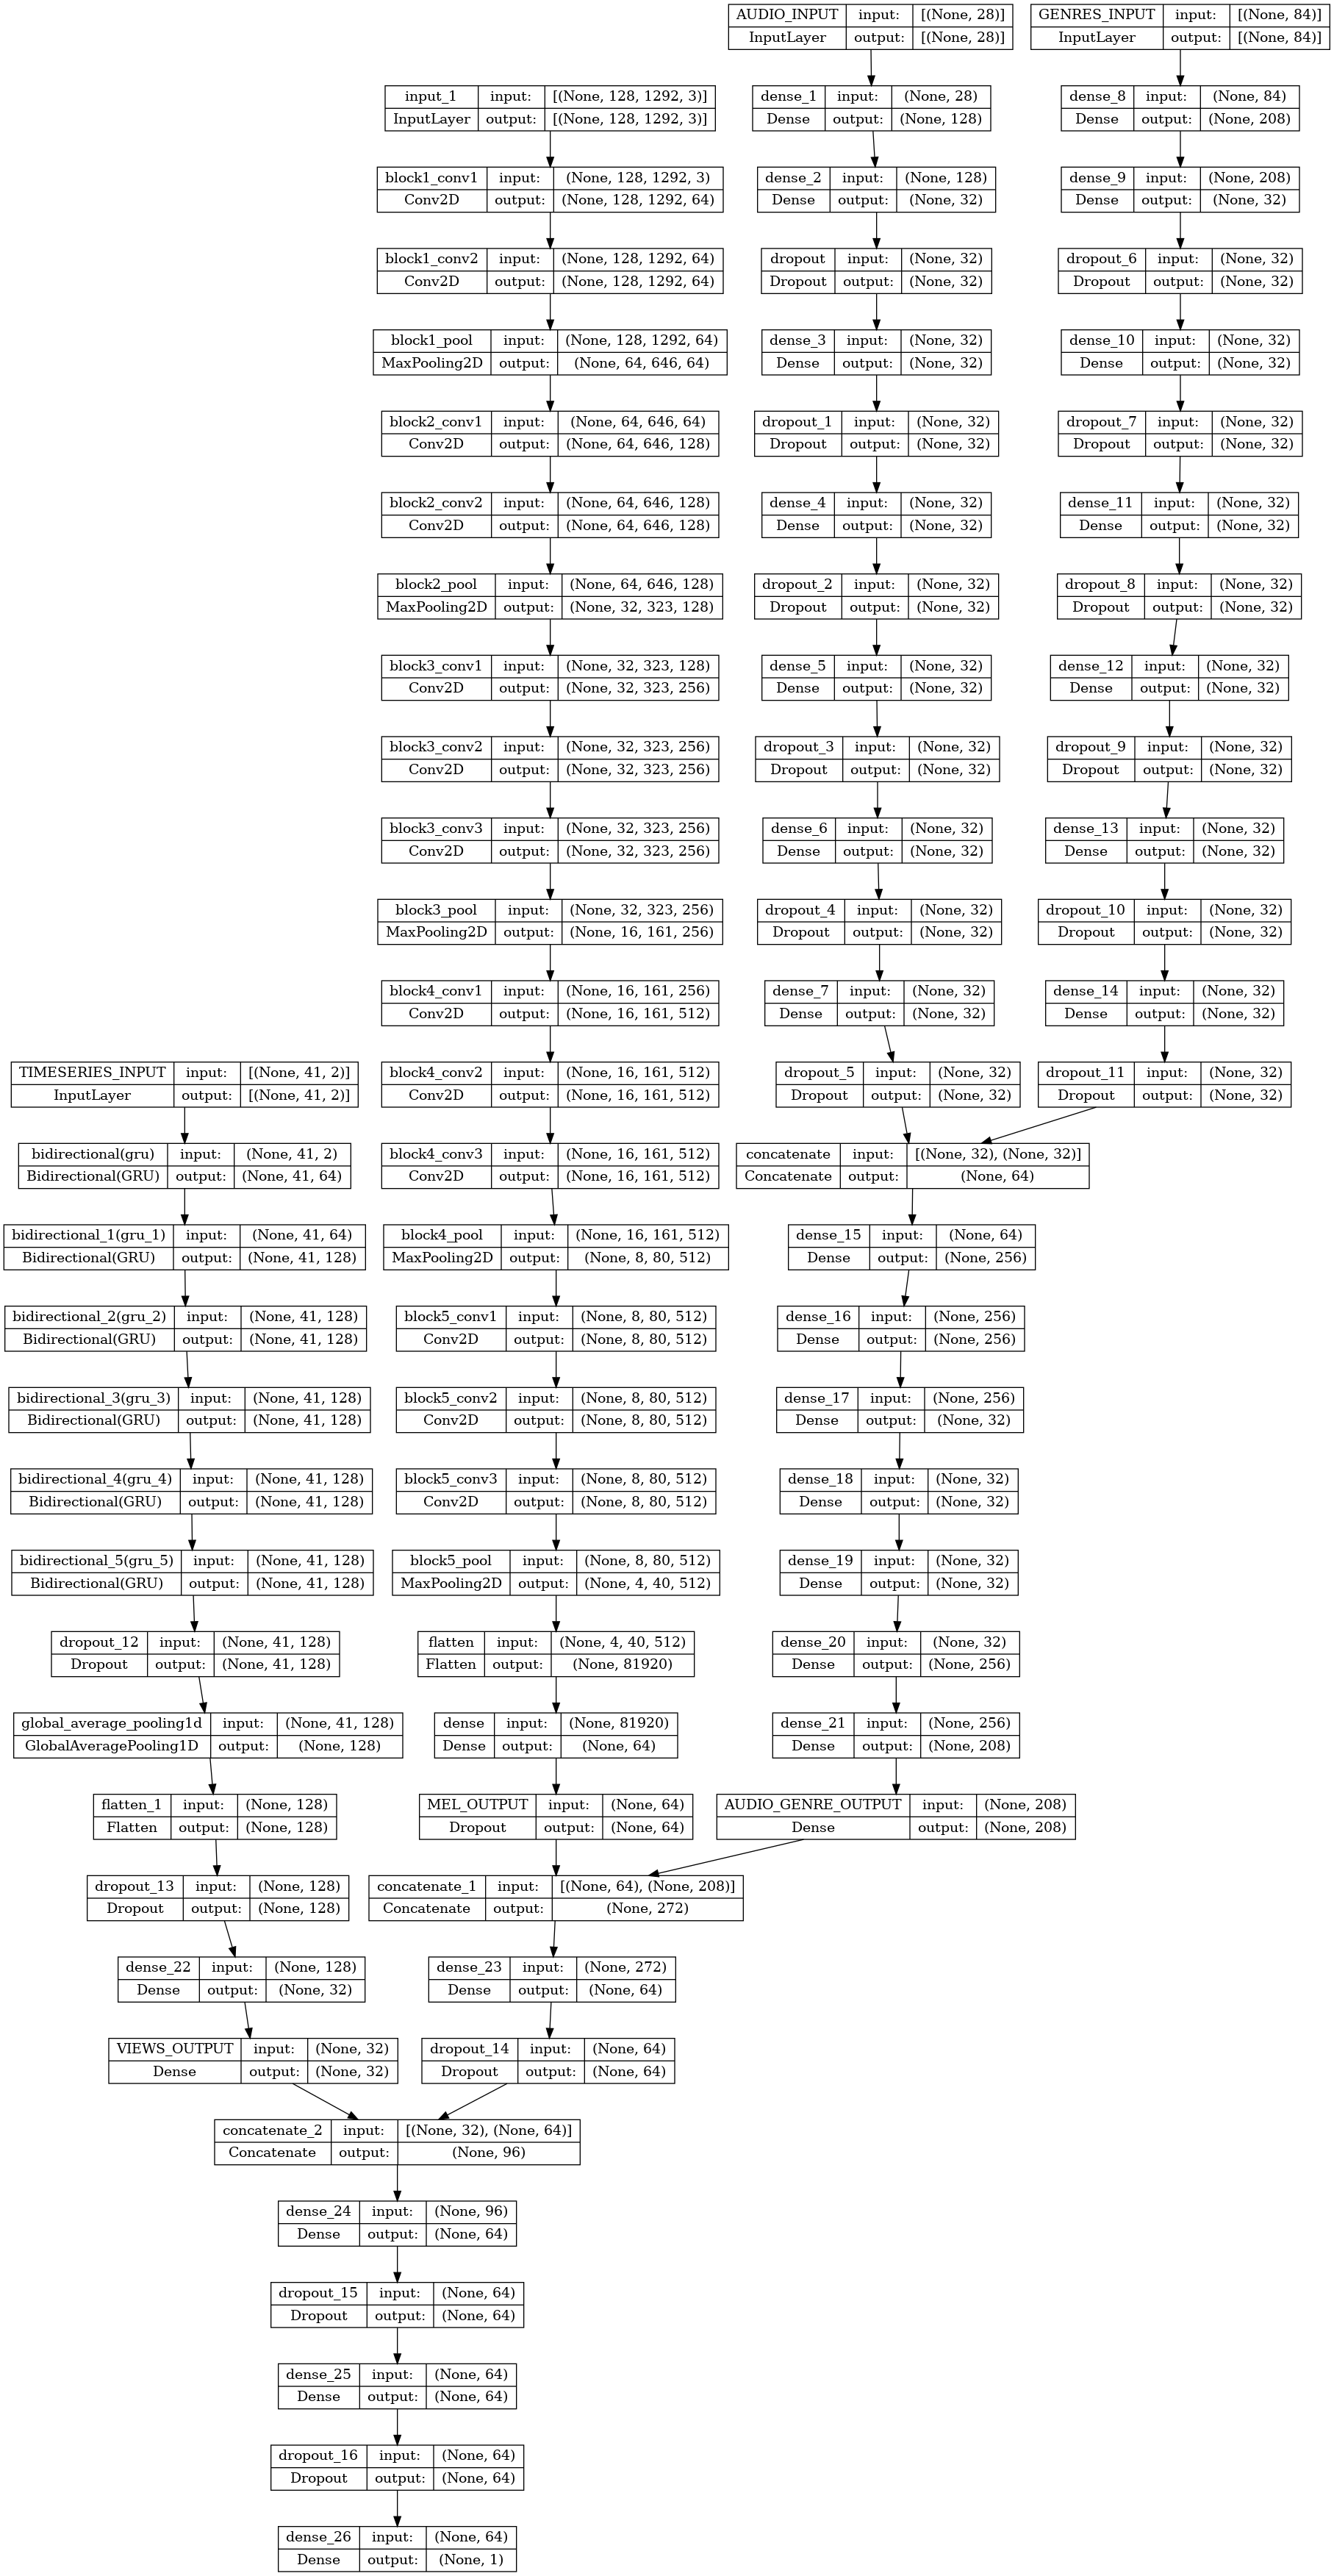

In [85]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [86]:
checkpoint = ModelCheckpoint(filepath='cnn_after_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

history = model.fit(
            training_generator,
            validation_data=validation_generator,
            epochs=20,
            #steps_per_epoch=len(X_audio_train)/16,
            callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/20


/tmp/ipykernel_172253/312765110.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = self.labels[[batch_indices]]


407/407 [==============================] - ETA: 0s - loss: 13.4558 - mse: 306.9520 - mae: 14.0279

2022-10-31 21:15:06.142009: W tensorflow/core/framework/op_kernel.cc:1733] UNKNOWN: IndexError: index 1075 is out of bounds for axis 0 with size 1075
Traceback (most recent call last):

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1030, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/venv/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 831, in wrapped_generator
    for data in generator_fn():

  File "/opt/venv/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 957, in generator_fn
    yield x[i]

  File "/tmp/ipykernel_172253/312765110.py", line 39, in __getitem__
    audio, gen

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  IndexError: index 1075 is out of bounds for axis 0 with size 1075
Traceback (most recent call last):

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1030, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/venv/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 831, in wrapped_generator
    for data in generator_fn():

  File "/opt/venv/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 957, in generator_fn
    yield x[i]

  File "/tmp/ipykernel_172253/312765110.py", line 39, in __getitem__
    audio, genre, views, y = self.__data_generation2(batch_indices)

  File "/tmp/ipykernel_172253/312765110.py", line 76, in __data_generation2
    views = np.stack(self.views[batch_indices,:,:])

IndexError: index 1075 is out of bounds for axis 0 with size 1075


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_6]]
  (1) UNKNOWN:  IndexError: index 1075 is out of bounds for axis 0 with size 1075
Traceback (most recent call last):

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/opt/venv/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1030, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/venv/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 831, in wrapped_generator
    for data in generator_fn():

  File "/opt/venv/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 957, in generator_fn
    yield x[i]

  File "/tmp/ipykernel_172253/312765110.py", line 39, in __getitem__
    audio, genre, views, y = self.__data_generation2(batch_indices)

  File "/tmp/ipykernel_172253/312765110.py", line 76, in __data_generation2
    views = np.stack(self.views[batch_indices,:,:])

IndexError: index 1075 is out of bounds for axis 0 with size 1075


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_228706]